In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv
/kaggle/input/coordinates/location.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # Датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # Датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # Самбмишн
location = pd.read_csv('/kaggle/input/coordinates/location.csv') # Дата-сет с извесными значениями координат, уже зарание определенными по адресу отеля

## 0. Предварительное знакомство с данными.

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [7]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [8]:
df_train.head(5)

hotel_address  \
0  Stratton Street Mayfair Westminster Borough Lo...   
1  130 134 Southampton Row Camden London WC1B 5AF...   
2   151 bis Rue de Rennes 6th arr 75006 Paris France   
3  216 Avenue Jean Jaures 19th arr 75019 Paris Fr...   
4          Molenwerf 1 1014 AG Amsterdam Netherlands   

   additional_number_of_scoring review_date  average_score  \
0                           581   2/19/2016            8.4   
1                           299   1/12/2017            8.3   
2                            32  10/18/2016            8.9   
3                            34   9/22/2015            7.5   
4                           914    3/5/2016            8.5   

                                  hotel_name reviewer_nationality  \
0                         The May Fair Hotel      United Kingdom    
1            Mercure London Bloomsbury Hotel      United Kingdom    
2          Legend Saint Germain by Elegancia               China    
3  Mercure Paris 19 Philharmonie La Villette      United Kingdom    
4                Golden Tulip Amsterdam West              Poland    

       negative_review  review_total_negative_word_counts  \
0             Leaving                                   3   
1       poor breakfast                                  3   
2   No kettle in room                                   6   
3          No Negative                                  0   
4         Torn sheets                                   4   

   total_number_of_reviews                                    positive_review  \
0                     1994                                 Staff were amazing   
1                     1361                                           location   
2                      406                                        No Positive   
3                      607   Friendly staff quiet comfortable room spotles...   
4                     7586   The staff was very friendly and helpful Break...   

   review_total_positive_word_counts  \
0                                  4   
1                                  2   
2                                  0   
3                                 11   
4                                 20   

   total_number_of_reviews_reviewer_has_given  reviewer_score  \
0                                           7            10.0   
1                                          14             6.3   
2                                          14             7.5   
3                                           8            10.0   
4                                          10             9.6   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Studio Suite ...           531 day   
1  [' Business trip ', ' Couple ', ' Standard Dou...           203 day   
2  [' Leisure trip ', ' Solo traveler ', ' Modern...           289 day   
3  [' Leisure trip ', ' Solo traveler ', ' Standa...           681 day   
4  [' Business trip ', ' Couple ', ' Standard Dou...           516 day   

         lat       lng  
0  51.507894 -0.143671  
1  51.521009 -0.123097  
2  48.845377  2.325643  
3  48.888697  2.394540  
4  52.385601  4.847060

In [9]:
df_test.head(5)

hotel_address  \
0                 Via Senigallia 6 20161 Milan Italy   
1  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   
2        Mallorca 251 Eixample 08008 Barcelona Spain   
3  Piazza Della Repubblica 17 Central Station 201...   
4  Singel 303 309 Amsterdam City Center 1012 WJ A...   

   additional_number_of_scoring review_date  average_score  \
0                           904   7/21/2017            8.1   
1                           612  12/12/2016            8.6   
2                            46  11/26/2015            8.3   
3                           241  10/17/2015            9.1   
4                           834   5/16/2016            9.1   

                                   hotel_name        reviewer_nationality  \
0                              Hotel Da Vinci             United Kingdom    
1                           Urban Lodge Hotel                    Belgium    
2  Alexandra Barcelona A DoubleTree by Hilton                     Sweden    
3                    Hotel Principe Di Savoia   United States of America    
4                              Hotel Esther a             United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   
2                                           Pillows    
3                                        No Negative   
4                                        No Negative   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   
1                                 10                     5018   
2                                  3                      351   
3                                  0                     1543   
4                                  0                     4687   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   
2                         Nice welcoming and service   
3   Everything including the nice upgrade The Hot...   
4                    Lovely hotel v welcoming staff    

   review_total_positive_word_counts  \
0                                 62   
1                                  0   
2                                  5   
3                                 27   
4                                  7   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   
2                                          15   
3                                           9   
4                                           2   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...           234 day   
2  [' Business trip ', ' Solo traveler ', ' Twin ...           616 day   
3  [' Leisure trip ', ' Couple ', ' Ambassador Ju...           656 day   
4  [' Business trip ', ' Solo traveler ', ' Class...           444 day   

         lat       lng  
0  45.533137  9.171102  
1  52.385649  4.834443  
2  41.393192  2.161520  
3  45.479888  9.196298  
4  52.370545  4.888644

In [10]:
sample_submission.head(5)

reviewer_score      id
0               1  488440
1              10  274649
2               3  374688
3              10  404352
4               9  451596

In [11]:
# Проверим наш датасет на наличие дубликатов
dupl_columns = list(df_train.columns)

mask = df_train.duplicated(subset=dupl_columns)
df_train_duplicates = df_train[mask]
print(f'Число найденных дубликатов: {df_train_duplicates.shape[0]}')

Число найденных дубликатов: 307


In [12]:
# Удалим дубликаты
df_train = df_train.drop_duplicates(subset=dupl_columns)
print(f'Результирующее число записей: {df_train.shape[0]}')

Результирующее число записей: 386496


In [13]:
# Объединяем df_train и df_test в один датасет
df_train['sample'] = 1 # Помечаем где у нас трейн
df_test['sample'] = 0 # Помечаем где у нас тест
df_test['reviewer_score'] = 0 # В тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = pd.concat([df_train, df_test], ignore_index=True) # Объединяем

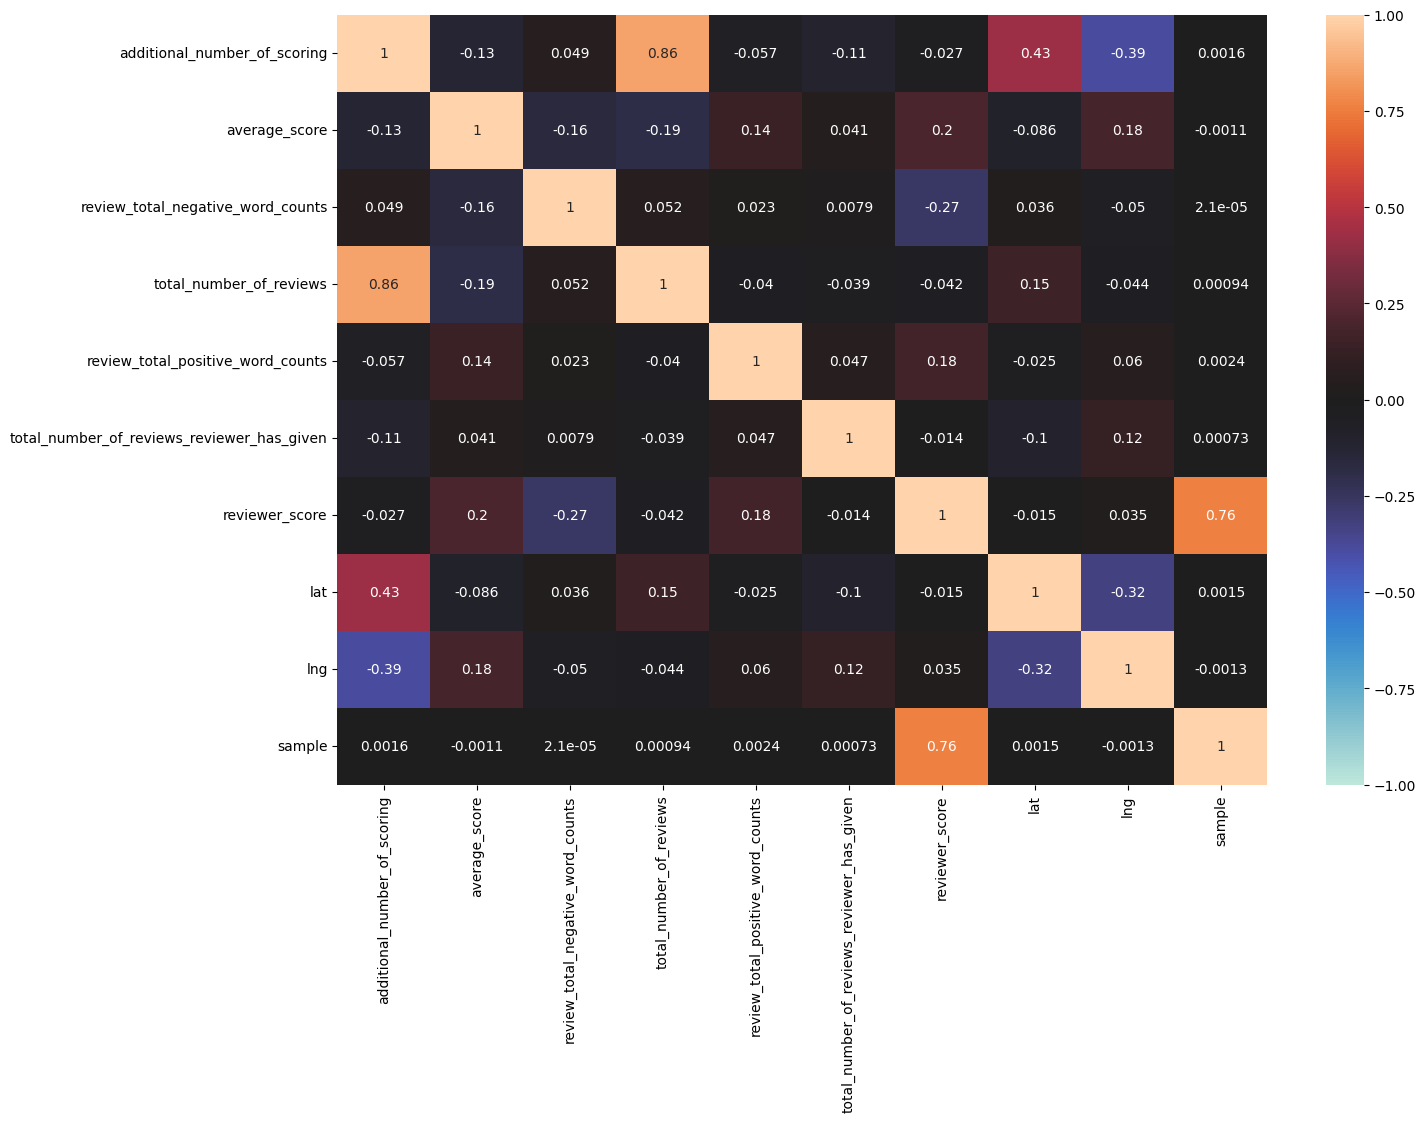

In [14]:
# Проверим корреляцию признаков с таргетинговым признаком "reviewer_score"
corr_view_data = data.corr(method = 'spearman', numeric_only = True)
plt.rcParams['figure.figsize'] = (15,10)

heatmap = sns.heatmap(corr_view_data, annot = True, vmin=-1, vmax=1, center= 0)

#### Как видно из тепловой матрицы признаки "review_total_negative_word_counts" и "average_score" неплохо коррелируют з целевым признаком. С остальними признаками корреляция слабая.

## 1. Очистка данных от пропущенных значений.

In [15]:
# Проверим датафрейм df_train на наличие пропусков в данных по столбцам в процентном отношении
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.634032
lng    0.634032
dtype: float64

In [16]:
# Определяем количество строк с пропусками 
display(data.isnull().sum())

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
dtype: int64

### Как видно выше, признаки lng и lat содержат по 3268 пропусков, что является меньше одного процента от значений для каждого из признаков.

In [17]:
# Посмотрим какие это значения
df_isnull = data.isnull() # Пометим пропуски через True
data_isnull = df_isnull[(df_isnull['lat'] == False)&(df_isnull['lng'] == False)] # Оставим лишь те строки, где не будет пропусков
hotels_null = data.drop(axis=0, index=data_isnull.index) # Удалим строки, где нет пропусков и посмотрим на результат
display(hotels_null) 

hotel_address  \
122      Savoyenstra e 2 16 Ottakring 1160 Vienna Austria   
566          23 Rue Damr mont 18th arr 75018 Paris France   
724     Josefst dter Stra e 10 12 08 Josefstadt 1080 V...   
754     W hringer Stra e 33 35 09 Alsergrund 1090 Vien...   
1137     4 rue de la P pini re 8th arr 75008 Paris France   
...                                                   ...   
514735   4 rue de la P pini re 8th arr 75008 Paris France   
514826  Sieveringer Stra e 4 19 D bling 1190 Vienna Au...   
514966  Landstra er G rtel 5 03 Landstra e 1030 Vienna...   
515293   Savoyenstra e 2 16 Ottakring 1160 Vienna Austria   
515309  Josefst dter Stra e 10 12 08 Josefstadt 1080 V...   

        additional_number_of_scoring review_date  average_score  \
122                               86   8/26/2016            8.3   
566                               21   6/23/2016            8.3   
724                              333    8/6/2015            8.3   
754                              214    1/4/2016            7.8   
1137                             172    1/5/2016            8.8   
...                              ...         ...            ...   
514735                           172    6/3/2016            8.8   
514826                           115    8/8/2016            8.0   
514966                           101    5/1/2017            8.5   
515293                            86   7/19/2016            8.3   
515309                           333    8/6/2016            8.3   

                                              hotel_name  \
122     Austria Trend Hotel Schloss Wilhelminenberg Wien   
566                         Holiday Inn Paris Montmartre   
724                  Fleming s Selection Hotel Wien City   
754                                        Hotel Atlanta   
1137              Maison Albar Hotel Paris Op ra Diamond   
...                                                  ...   
514735            Maison Albar Hotel Paris Op ra Diamond   
514826      Derag Livinghotel Kaiser Franz Joseph Vienna   
514966                               Hotel Daniel Vienna   
515293  Austria Trend Hotel Schloss Wilhelminenberg Wien   
515309               Fleming s Selection Hotel Wien City   

              reviewer_nationality  \
122      United States of America    
566                United Kingdom    
724          United Arab Emirates    
754                       Romania    
1137                   Luxembourg    
...                            ...   
514735             United Kingdom    
514826                    Austria    
514966                    Austria    
515293                     France    
515309                    Ireland    

                                          negative_review  \
122                                              Not much   
566                                                   N a   
724                The bed so comfortable and room design   
754                                           No Negative   
1137       The breakfast was to minimalist for this price   
...                                                   ...   
514735   Cost was considerably cheaper had I booked cl...   
514826                  internet did not work in the room   
514966                                        No Negative   
515293   There was no warm water The bathroom was very...   
515309   The shower and toilet are in two separate roo...   

        review_total_negative_word_counts  total_number_of_reviews  \
122                                     3                     1558   
566                                     3                      298   
724                                     8                     3672   
754                                     0                     2724   
1137                                    9                     1524   
...                                   ...                      ...   
514735                                 11                     1524   
514826                             

### Определим пропущенные значениях для координат с помощью библиотеки geopy по адресам. 

In [18]:
# Узнаем какое общее количество уникальных значений для признака с адресом отеля hotel_address среди значений, где координаты отеля не указаны
n = hotels_null['hotel_address'].nunique()
print(f'Количество уникальных значений адреса отеля, в которых отсутвуют координаты составляет {n}')

Количество уникальных значений адреса отеля, в которых отсутвуют координаты составляет 17


In [19]:
# Выведем на экран список уникальных адресов отелей, для которых нет координат
hotels_adress_null_list = list(hotels_null['hotel_address'].value_counts().index)
print(hotels_adress_null_list)

['Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria', 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria', 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria', '4 rue de la P pini re 8th arr 75008 Paris France', 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria', 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria', 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria', 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria', 'Bail n 4 6 Eixample 08010 Barcelona Spain', 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria', 'Hasenauerstra e 12 19 D bling 1190 Vienna Austria', 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria', '23 Rue Damr mont 18th arr 75018 Paris France', 'Paragonstra e 1 11 Simmering 1110 Vienna Austria', '20 Rue De La Ga t 14th arr 75014 Paris France', 'Pau Clar s 122 Eixample 08009 Barcelona Spain', 'Sep lveda 180 Eixample 08011 Barcelona Spain']


### Для удобства в дальнейшем и чтобы cэкономить ресурсы компьютера создадим дата-фрейм location со всеми 17 уникальными адресами на стационарном компьютере, а затем вручную заполним пропущенные значения координат с помощью библиотеки geopy.

In [20]:
# Выведем на экран адреса отелей и их кординаты найденные с помощью geopy
display(location)

Unnamed: 0                                      hotel_address   latitude  \
0            0  Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  48.209235   
1            1  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  48.212663   
2            2  W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  48.220301   
3            3   4 rue de la P pini re 8th arr 75008 Paris France  48.875248   
4            4  Landstra er G rtel 5 03 Landstra e 1030 Vienna...  48.188863   
5            5  W hringer Stra e 12 09 Alsergrund 1090 Vienna ...  48.216813   
6            6   Savoyenstra e 2 16 Ottakring 1160 Vienna Austria  48.219571   
7            7  Sieveringer Stra e 4 19 D bling 1190 Vienna Au...  48.246066   
8            8          Bail n 4 6 Eixample 08010 Barcelona Spain  41.391720   
9            9  Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  48.220892   
10          10  Hasenauerstra e 12 19 D bling 1190 Vienna Austria  48.233523   
11          11  Josefst dter Stra e 22 08 Josefstadt 1080 Vien...  48.209664   
12          12       23 Rue Damr mont 18th arr 75018 Paris France  48.888881   
13          13   Paragonstra e 1 11 Simmering 1110 Vienna Austria  48.186721   
14          14      20 Rue De La Ga t 14th arr 75014 Paris France  48.839939   
15          15      Pau Clar s 122 Eixample 08009 Barcelona Spain  41.392715   
16          16       Sep lveda 180 Eixample 08011 Barcelona Spain  41.383234   

    longitude  
0   16.355225  
1   16.379168  
2   16.355883  
3    2.323375  
4   16.383852  
5   16.359936  
6   16.285625  
7   16.341262  
8    2.177681  
9   16.366633  
10  16.345655  
11  16.351426  
12   2.333195  
13  16.420653  
14   2.323675  
15   2.167492  
16   2.162940

In [21]:
# Теперь заполним пропуски для координат по извесным адресам
for i in range(len(hotels_adress_null_list)):
    values_coord_dict = {'lat': location[location['hotel_address'] == hotels_adress_null_list[i]].loc[i,'latitude'], 'lng': location[location['hotel_address'] == hotels_adress_null_list[i]].loc[i,'longitude']}
    data[data['hotel_address'] == hotels_adress_null_list[i]] = data[data['hotel_address'] == hotels_adress_null_list[i]].fillna(value=values_coord_dict)

In [22]:
# Проверим количество пропусков, чтобы удостовериться, что пропусков больше нет
data.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
dtype: int64

## 2. Создание новых признаков.

In [23]:
# Создадим новый признак hotel_country, страна в которой находится отель
data['hotel_country'] = data['hotel_address'].apply(lambda x: "United Kingdom" if x.split()[-1] == 'Kingdom' else x.split()[-1])

In [24]:
# Создадим новый признак hotel_city, город в котором находится отель
data['hotel_city'] = data['hotel_address'].apply(lambda x: x.split()[-5] if x.split()[-2] == 'United' else x.split()[-2])

In [25]:
# Поработаем з признаком "reviewer_nationality"
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x[1:-1]) # Уберем для удобства лишние пробелы в начале и конце
nationality_list = list(data['reviewer_nationality'].value_counts().index) # Создадим список всех национальностей посетителей 

#### Из ежегодного доклада ООН об индексе счастья по странам возмем данные за 2017 год, так как он должен учитывать данные за предыдущие два года года. Данные брал отсюда: https://worldhappiness.report/ed/2017/

In [26]:
# Создаем словарь с коэффициентами счастья)
dict_index_of_happiness = {
'Norway': 7.537,
'Denmark': 7.522,
'Iceland': 7.504,
'Switzerland': 7.494,
'Finland': 7.469,
'Netherlands': 7.377,
'Canada': 7.316,
'New Zealand': 7.314,
'Australia': 7.284,
'Sweden': 7.284,
'Israel': 7.213,
'Costa Rica': 7.079,
'Austria': 7.006,
'United States of America': 6.993,
'Ireland': 6.977,
'Germany': 6.951,
'Belgium': 6.891,
'Luxembourg': 6.863,
'United Kingdom': 6.714,
'Chile': 6.652,
'United Arab Emirates': 6.648,
'Brazil': 6.635,
'Czech Republic': 6.609,
'Argentina': 6.599,
'Mexico': 6.578,
'Singapore': 6.572,
'Malta': 6.527,
'Uruguay': 6.454,
'Guatemala': 6.454,
'Panama': 6.452,
'France': 6.442,
'Thailand': 6.424,
'Taiwan': 6.422,
'Spain': 6.403,
'Qatar': 6.375,
'Colombia': 6.357,
'Saudi Arabia': 6.344,
'Trinidad and Tobago': 6.168,
'Kuwait': 6.105,
'Slovakia': 6.098,
'Bahrain': 6.087,
'Malaysia': 6.084,
'Nicaragua': 6.071,
'Ecuador': 6.008,
'El Salvador': 6.003,
'Poland': 5.973,
'Uzbekistan': 5.971,
'Italy': 5.964,
'Russia': 5.963,
'Belize': 5.956,
'Japan': 5.920,
'Lithuania': 5.902,
'Algeria': 5.872,
'Latvia': 5.850,
'South Korea': 5.838,
'Moldova': 5.838,
'Romania': 5.825,
'Bolivia': 5.823,
'Turkmenistan': 5.822,
'Kazakhstan': 5.819,
'Cyprus': 5.810,
'Slovenia': 5.758,
'Peru': 5.715,
'Mauritius': 5.629,
'Cyprus': 5.621,
'Estonia': 5.611,
'Belarus': 5.569,
'Libya': 5.525,
'Turkey': 5.500,
'Paraguay': 5.493,
'Philippines': 5.430,
'Serbia': 5.395,
'Jordan': 5.336,
'Hungary': 5.324,
'Jamaica': 5.311,
'Croatia': 5.293,
'Kosovo': 5.279,
'China': 5.273,
'Pakistan': 5.269,
'Indonesia': 5.262,
'Venezuela': 5.250,
'Montenegro': 5.237,
'Morocco': 5.235,
'Azerbaijan': 5.234,
'Dominican Republic': 5.230,
'Greece': 5.227,
'Lebanon': 5.225,
'Portugal': 5.195,
'Bosnia and Herzegovina': 5.182,
'Honduras': 5.181,
'Macedonia': 5.175,
'Somalia': 5.151,
'Vietnam': 5.074,
'Nigeria': 5.074,
'Tajikistan': 5.041,
'Bhutan': 5.011,
'Kyrgyzstan': 5.004,
'Nepal': 4.962,
'Mongolia': 4.955,
'South Africa': 4.829,
'Tunisia': 4.805,
'Palestinian Territory': 4.775,
'Egypt': 4.735,
'Bulgaria': 4.714,
'Sierra Leone': 4.709,
'Cameroon': 4.695,
'Iran': 4.692,
'Albania': 4.644,
'Bangladesh': 4.608,
'Namibia': 4.574,
'Kenya': 4.553,
'Mozambique': 4.550,
'Myanmar': 4.545,
'Senegal': 4.535,
'Zambia': 4.514,
'Iraq': 4.497,
'Gabon': 4.465,
'Ethiopia': 4.460,
'Sri Lanka': 4.440,
'Armenia': 4.376,
'India': 4.315,
'Mauritania': 4.292,
'Congo': 4.291,
'Georgia': 4.286,
'Democratic Republic of the Congo': 4.280,
'Mali': 4.190,
'Ivory Coast': 4.180,
'Cambodia': 4.168,
'Sudan': 4.139,
'Ghana': 4.120,
'Ukraine': 4.096,
'Uganda': 4.081,
'Burkina Faso': 4.032,
'Niger': 4.028,
'Malawi': 3.970,
'Chad': 3.936,
'Zimbabwe': 3.875,
'Lesotho': 3.808,
'Angola': 3.795,
'Afghanistan': 3.794,
'Botswana': 3.766,
'Benin': 3.657,
'Madagascar': 3.644,
'Haiti': 3.603,
'Yemen': 3.593,
'South Sudan': 3.591,
'Liberia': 3.533,
'Guinea': 3.507,
'Togo': 3.495,
'Rwanda': 3.471,
'Syria': 3.462,
'Tanzania': 3.349,
'Burundi': 2.905,
'Central Africa Republic' : 2.693,
'Hong Kong': 5.472
}

In [27]:
# Создаем новый признак "index_of_happiness"
# Заполняем признак согласно значениям из словая dict_index_of_happiness, если страны не будет словаре, то заполняем его средним арифметическим
data['index_of_happiness'] = data['reviewer_nationality'].apply(lambda x: dict_index_of_happiness[x] if x in list(dict_index_of_happiness.keys()) else sum(list(dict_index_of_happiness.values()))/len(list(dict_index_of_happiness.values())))

In [28]:
# Сделаем список топ-5 стран национальностей людей писавших отзывы
top_5_nationality = list(data['reviewer_nationality'].value_counts(normalize=True).nlargest(5).index)
# Закодируем признак reviewer_nationality следующим способом:
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'United Kingdom' if x==top_5_nationality[0] else 'United States of America' if x==top_5_nationality[1] else 'Australia' if x==top_5_nationality[2] else 'Ireland' if x==top_5_nationality[3] else 'United Arab Emirates' if x==top_5_nationality[4]  else 'Other')

In [29]:
# Посмотрим какие уникальные города попали в опрос booking
print(list(data['hotel_city'].value_counts().index))

['London', 'Barcelona', 'Paris', 'Amsterdam', 'Vienna', 'Milan']


#### Известно,что из этого списка лишь Milan и Barcelona не являются столицами.

In [30]:
# Создадим новый признак city_population население города. В связи с тем, что парсинг сайтов из kaggle затруднен, возьмем информацию про население городов из интернета за 2016 год
data['city_population'] = data['hotel_city'].apply(lambda x: 8788000 if x == 'London' else 5348000 if x == 'Barcelona' else 10789000 if x == 'Paris' else 1115000 if x == 'Amsterdam' else 1857000 if x == 'Vienna' else 3113000)

In [31]:
# Создадим новый признак is_capital является ли город, в котором находится отель столицей. Если является - 1, если нет - 0
data['is_capital'] = data['hotel_city'].apply(lambda x: 1 if x in ['London', 'Paris', 'Amsterdam', 'Vienna'] else 0)

In [32]:
# Теперь поработаем с тегами
# С помощью регулярного выражения разобъем для удобства в дальнейшем строку тегов по словам
import re
regex = "'.*?'"
data['tags'] = data['tags'].str.findall(regex)

In [33]:
def remove_spaces(tags):
    
    """Функция предназначенная для удаления пробелов и ненужных символов в словах"""
    
    tags_list = list(map(lambda tag: tag[2:-2], tags))
    
    return tags_list

In [34]:
# Удалим из признака tags ненужные символы и лишние пробелы
data['tags'] = data['tags'].apply(remove_spaces)

In [35]:
# Создадим новый признак tags_number, количество тегов
data['tags_numbers'] = data['tags'].apply(lambda x: len(x))

In [36]:
# В тегах встречается упоминание о количестве проведеннных ночей в отеле.
# Напишем функцию для подсчета количества ночей, проведенных в отеле путешественниками.

def get_num_nights(tags):
    
    """Функция для получения количества проведенных ночей в отеле"""
    

    for i in range(len(tags)): # Пройдем по всем фразам в тегах.
        
        for j in range(len(tags[i].split())): # Разобъем теги на слова.
            
            if (tags[i].split()[j] == 'night') or (tags[i].split()[j] == 'nights'): # Если в тегах будет встречаться слова night или nights 
                
                if tags[i].split()[j-1] == 'the': # и перед ним идет слово the,
                    break # то ищем совпадения в следующем теге.
                else:
                    return int(tags[i].split()[j-1]) # Если перед искомыми словами нет слова the, просим функцию вернуть количество ночей в целочисленном формате.
                          
            else:
                continue # Если мы не нашли в тегах икомых слов night или nights, просим функцию искать дальше.
                
    return 0 # Если функция не нашла искомые слова просим вернуть 0 ночей


In [37]:
# Создадим новый признак nights_number количество дней проведенных в отеле
data['nights_number'] = data['tags'].apply(get_num_nights)

In [38]:
# Преобразуем наш признак nights_number количество дней проведенных в отеле в категориальный признак.
# Закодируем его следующим образом: если человек прожил 1 день, то это 'Trip', если прожил от 2 дня, то это "Journey", а если от 3 до семи дней, то "Tour", а все что больше 7 будет "Other"
data['nights_number'] = data['nights_number'].apply(lambda x: 'Trip' if x == 1 else 'Journey' if x == 2 else 'Tour' if 3 <= x <= 7 else 'Other')

In [39]:
# В тегах встречается упоминание о видах путешествия.
# Напишем функцию для получения вида путешествия из тегов.

def get_type_trip(tags):
    
    """Функция для получения вида путешествия из тегов"""
    
    for i in range(len(tags)): # Пройдем по всем фразам в тегах.
        
        for j in range(len(tags[i].split())): # Разобъем теги на слова.
            
            if (tags[i].split()[j] == 'trip'): # Если в тегах стречается слово trip, то  просим функцию вернуть весь тег целиком
                return tags[i]            
            else:
                continue # Если мы не нашли в тегах икомых слов trip, просим функцию искать дальше.
                
    return None # Если функция ничего не найдет попросим ее вернуть None


In [40]:
# Создадим новый признак travel_type вид путешествия
data['travel_type'] = data['tags'].apply(get_type_trip)

In [41]:
# В тегах встречается описание типа группы по количеству путешественников.
# Напишем функцию для получения типа группы по величине из тегов.

def get_type_traveler(tags):
    
    """Функция для получения типа группы по величине из тегов"""
    
    for i in range(len(tags)): # Пройдем по всем фразам в тегах.
        
        if ((tags[i] == 'Solo traveler') or (tags[i] == 'Couple') or (tags[i] == 'Group') or (tags[i] == 'Travelers with friends') or (tags[i] == 'Family with young children') or (tags[i] == 'Family with older children')): # Если в тегах стречается искомые слова,
            return tags[i] # то просим функцию вернуть весь тег целиком
        else:
            continue # Если мы не нашли в тегах икомые слова, просим функцию искать дальше
                
    return None # Если функция ничего не найдет попросим ее вернуть None

In [42]:
# Создадим новый признак traveler_type типа группы путешественников по величине
data['traveler_type'] = data['tags'].apply(get_type_traveler)

In [43]:
# В тегах встречается описание типа номера отеля.
# Напишем функцию для получения типа номера отеля из тегов.

def get_type_room(tags):
    
    """Функция для получения типа типа номера отеля из тегов"""
    
    for i in range(len(tags)): # Пройдем по всем фразам в тегах.
        
        for j in range(len(tags[i].split())): # Разобъем теги на слова.
            
            if (tags[i].split()[j] == 'room') or (tags[i].split()[j] == 'rooms') or (tags[i].split()[j] == 'Room') or (tags[i].split()[j] == 'Rooms'): # Если в тегах стречается слово trip, то  просим функцию вернуть весь тег целиком
                return tags[i]
            elif tags[i] == 'Junior Suite':
                return tags[i]
            else:
                continue # Если мы не нашли в тегах икомых слов trip, просим функцию искать дальше.
                
    return None # Если функция ничего не найдет попросим ее вернуть None

In [44]:
# Создадим новый признак type_room тип номера отеля
data['type_room'] = data['tags'].apply(get_type_room)

In [45]:
# Создадим новый признак is_a_pet есть ли у путешественников домашннее животное. Закодируем его следующим образом: если есть - 1, если нет - 0. 
data['is_a_pet'] = data['tags'].apply(lambda x: 1 if 'With a pet' in x else 0)

In [46]:
# Создадим новый признак is_mobile_devices отправлен ли отзыв по телефону. Закодируем его следующим образом: 1 - отзыв отправлен через мобильное устройство, 0 - отзыв отправлен через другое устройство. 
data['is_mobile_devices'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [47]:
# Преобразуем признак review_date дату отзыва в формат datetime
data['review_date'] =  pd.to_datetime(data['review_date'])

In [48]:
# Создадим новый признак review_year год отзыва
data['review_year'] = data['review_date'].dt.year

In [49]:
# Создадим новый признак review_month месяц года отзыва
data['review_month'] = data['review_date'].dt.month

In [50]:
# Создадим новый признак review_dayofweek номер дня недели отзыва
data['review_day_of_week'] = data['review_date'].dt.dayofweek

In [51]:
# На основе предыдущего признака review_day_of_week создадим новый признак is_weekend является ли день выходным.
# Закодируем его следующим образом: 1 - если это выходной, 0 - если будничный день. 
data['is_weekend'] = data['review_day_of_week'].apply(lambda x: 1 if x==5 or x==6 else 0)

In [52]:
# Создадим новый признак review_season_of_year пора года и закодируем следующим образом: "Winter" - если значение месяца 1,2,12, "Spring" - если значение 3-5, "Summer" - если значение 6-8, "Autumn" - если значение 9-11. 
data['review_season_of_year'] = data['review_month'].apply(lambda x: 'Winter' if (x==1) or (x==2) or (x==12) else 'Spring' if (x==3) or (x==4) or (x==5) else 'Summer' if (x==6) or (x==7) or (x==8) else 'Autumn')

In [53]:
# Преобразуем признак days_since_review в целочисленный формат int
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(x.split()[0]))

In [54]:
def change_negative_review(review):
    
    """Функция для упрощения значений негативных комментариев"""
    
    review = review.strip().lower() # Приведем все значения к нижнему регистру
    
    # Создадим список из слов, которые выражают нейтральный смысл
    neutral_word_list = ['na', 'n a', 'nan', 'non', 'nane', 'none', 'nothing', 'nothings', 'good', 'ok', 'anything', 'anythings', 'good', 'negative', 'negatives', 'everything', 'everythings', 'n', 'problems']
    
    if (review == 'no') or (review == 'no complaints') or (review == ' ') or (review == ''): # Если отзыв содержит односложные слова, либо пропуски
        
        return 'neutral' # Просим вернуть neutral
    
    else: # Иначе
        
        for word in review.split(): # Разбиваем отзыв на слова
        
            if word in neutral_word_list: # Если слово из отзыва будет из нейтрального списка,
                return 'neutral' # то просим функцию вернуть neutral
            else:
                continue # Если функция ничего не находит просим ее продолжать поиски
            
        return len(review.split()) # Для удобства при создании нового признака, просим вернуть функцию количество слов в отзыве, которые не содержат нейтральных слов, то есть точно содержат негатив

In [55]:
# Немного преобразуем значения признака negative_review
data['negative_review'] = data['negative_review'].apply(change_negative_review)

In [56]:
# Теперь можем разбить негативные коментарии из признака "negative_review" по уровню негативности следующим образом: если количество слов в негативном коментарии от 0 до 6 - "first", 
# от 7 до 20 - "second", от 21 до 100 - "third" и более 101 - "fourth".
data['negative_range_review'] = data['negative_review'].apply(lambda x: 'neutral' if x=='neutral' else "first" if 0 <= x <= 5 else "second" if 6 <= x <= 20 else "third" if  21 <= x <= 60 else 'fourth')

In [57]:
# Напишем функцию для упрощения значений для положительных отзывов

def change_positive_review(review):
    
    """Функция для упрощения значений позитивных комментариев"""
    
    review = review.strip().lower() # Приведем все значения к нижнему регистру
    
    # Создадим список из слов, которые выражают нейтральный смысл
    neutral_word_list = ['na', 'n a', 'nan', 'non', 'nane', 'none', 'nothing', 'nothings', 'anything', 'anythings', 'everything', 'everythings', 'n', 'problems']
    
    if (review == 'no positive') or (review == 'no complaints') or (review == ' ') or (review == ''): # Если отзыв содержит односложные слова, либо пропуски
        
        return 'neutral' # Просим вернуть neutral
    
    else: # Иначе
        
        for word in review.split(): # Разбиваем отзыв на слова
        
            if word in neutral_word_list: # Если слово из отзыва будет из нейтрального списка,
                return 'neutral' # то просим функцию вернуть neutral
            else:
                continue # Если функция ничего не находит просим ее продолжать поиски
            
        return len(review.split()) # Для удобства при создании нового признака, просим вернуть функцию количество слов в отзыве, которые не содержат нейтральных слов, то есть точно содержат позитив

In [58]:
# Немного преобразуем значения признака positive_review
data['positive_review'] = data['positive_review'].apply(change_positive_review)

In [59]:
# Теперь можем разбить негативные коментарии из признака "negative_review" по уровню негативности следующим образом: если количество слов в негативном коментарии от 0 до 6 - "first", 
# от 7 до 20 - "second", от 21 до 100 - "third" и более 101 - "fourth".
data['positive_range_review'] = data['positive_review'].apply(lambda x: 'neutral' if x=='neutral' else "first" if 0 <= x <= 6 else "second" if 7 <= x <= 20 else "third" if  21 <= x <= 100 else 'fourth')

In [60]:
# Выведем список признаков и количество пропусков в процентах на экран
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)

display(cols_with_null)

type_room      5.846757
travel_type    2.911932
dtype: float64

#### Как видно выше лишь в признаках "travel_type" и "type_room" есть пропуски в значениях.

In [61]:
# Заменим пропуски для признаков travel_type, type_room на модальное значение.
values = { # Создадим словарь с именами столбцов, пропуски в которых нужно заменить на значения, которые указаны
    'travel_type': data['travel_type'].mode()[0],
    'type_room': data['type_room'].mode()[0]
}
# Заполняем оставшиеся записи константами в соответствии со словарем values
data = data.fillna(values)

# Выводим результирующую долю пропусков
display(data.isnull().sum())

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
hotel_country                                 0
hotel_city                                    0
index_of_happiness                      

In [62]:
# Создадим новый признак "is_bonus" есть ли еще что-то в комнате
data['is_bonus'] = data['type_room'].apply(lambda x: 1 if 'with' in x.split() else 0)

In [63]:
# Перекодируем признак "type_room" в зависимости от размеров номера следующим образом:
data['type_room'] = data['type_room'].apply(lambda x: 'Single' if 'Single' in x.split() else 'Double' if 'Double' in x.split() else 'Triple' if 'Triple' in x.split() else 'Single') 

In [64]:
data['travel_type'].value_counts(normalize=True)*100

travel_type
Leisure trip     83.919477
Business trip    16.080523
Name: proportion, dtype: float64

#### Признака "travel_type" имеет лишь 2 уникальных значения, следовательно его можно закодировать двоичным кодом. Все значений Leisure trip кодируем 1, все значения Business trip кодируем 0.

In [65]:
# Перекодируем признак 'travel_type'
data['travel_type'] = data['travel_type'].apply(lambda x: 1 if x=='Leisure trip' else 0)

In [66]:
# Теперь можно удалить ненужные признаки в формате строки object
data = data.drop(axis = 1, columns = ['hotel_address', 'review_date', 'negative_review', 'positive_review', 'tags', 'hotel_name'])

## 3. Кодирование категориальных признаков.

### 3.1 Закодируем порядковые категориальные признаки.

#### Признаки "nights_number", "type_room", "negative_range_review" и "positive_range_review" будет являться порядковым категориальным. Закодируем их.

In [67]:
# Импортируем библиотеку для кодирования категориальных признаков
import category_encoders as ce 

In [68]:
# Cоздаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'nights_number',
	'mapping': {'Trip': 1, 'Journey': 2, 'Other': 3, 'Tour': 4}
}])

# Применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data[['nights_number']])

# Удаляем старый признак traveler_type
data = data.drop(axis=1,columns='nights_number')

# Добавляем результат к исходному DataFrame
data = pd.concat([data, data_bin], axis=1)

In [69]:
# Cоздаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'type_room',
	'mapping': {'Single': 1, 'Double': 2, 'Triple': 3}
}])

# Применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data[['type_room']])

# Удаляем старый признак traveler_type
data = data.drop(axis=1,columns='type_room')

# Добавляем результат к исходному DataFrame
data = pd.concat([data, data_bin], axis=1)

In [70]:
# Cоздаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'negative_range_review',
	'mapping': {'neutral': 1, 'first': 2, 'second': 3, 
                'third': 4, 'fourth': 5}
}])

# Применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data[['negative_range_review']])

# Удаляем старый признак traveler_type
data = data.drop(axis=1,columns='negative_range_review')

# Добавляем результат к исходному DataFrame
data = pd.concat([data, data_bin], axis=1)

In [71]:
# Cоздаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'positive_range_review',
	'mapping': {'neutral': 1, 'first': 2, 'second': 3, 
                'third': 4, 'fourth': 5}
}])

# Применяем трансформацию к столбцу
data_bin = ord_encoder.fit_transform(data[['positive_range_review']])

# Удаляем старый признак traveler_type
data = data.drop(axis=1,columns='positive_range_review')

# Добавляем результат к исходному DataFrame
data = pd.concat([data, data_bin], axis=1)

### 3.2 Закодируем номинальные категориальные признаки.

#### Закодируем однократным "горячим" кодированием некоторые признаки.

In [72]:
data = pd.get_dummies(data, columns=['hotel_country', 'hotel_city', 'review_year', 'review_month', 'review_day_of_week', 'review_season_of_year', 'reviewer_nationality', 'traveler_type'])

## 4. Анализ мультиколлинеарности.

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 74 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   515431 non-null  int64  
 1   average_score                                  515431 non-null  float64
 2   review_total_negative_word_counts              515431 non-null  int64  
 3   total_number_of_reviews                        515431 non-null  int64  
 4   review_total_positive_word_counts              515431 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given     515431 non-null  int64  
 6   reviewer_score                                 515431 non-null  float64
 7   days_since_review                              515431 non-null  int64  
 8   lat                                            515431 non-null  float64
 9   lng                                  

In [74]:
# Непрерывные числовые признаки
num_cols = ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'index_of_happiness', 'city_population']

# Категориальные признаки
cat_cols = list(data.columns)[13:]

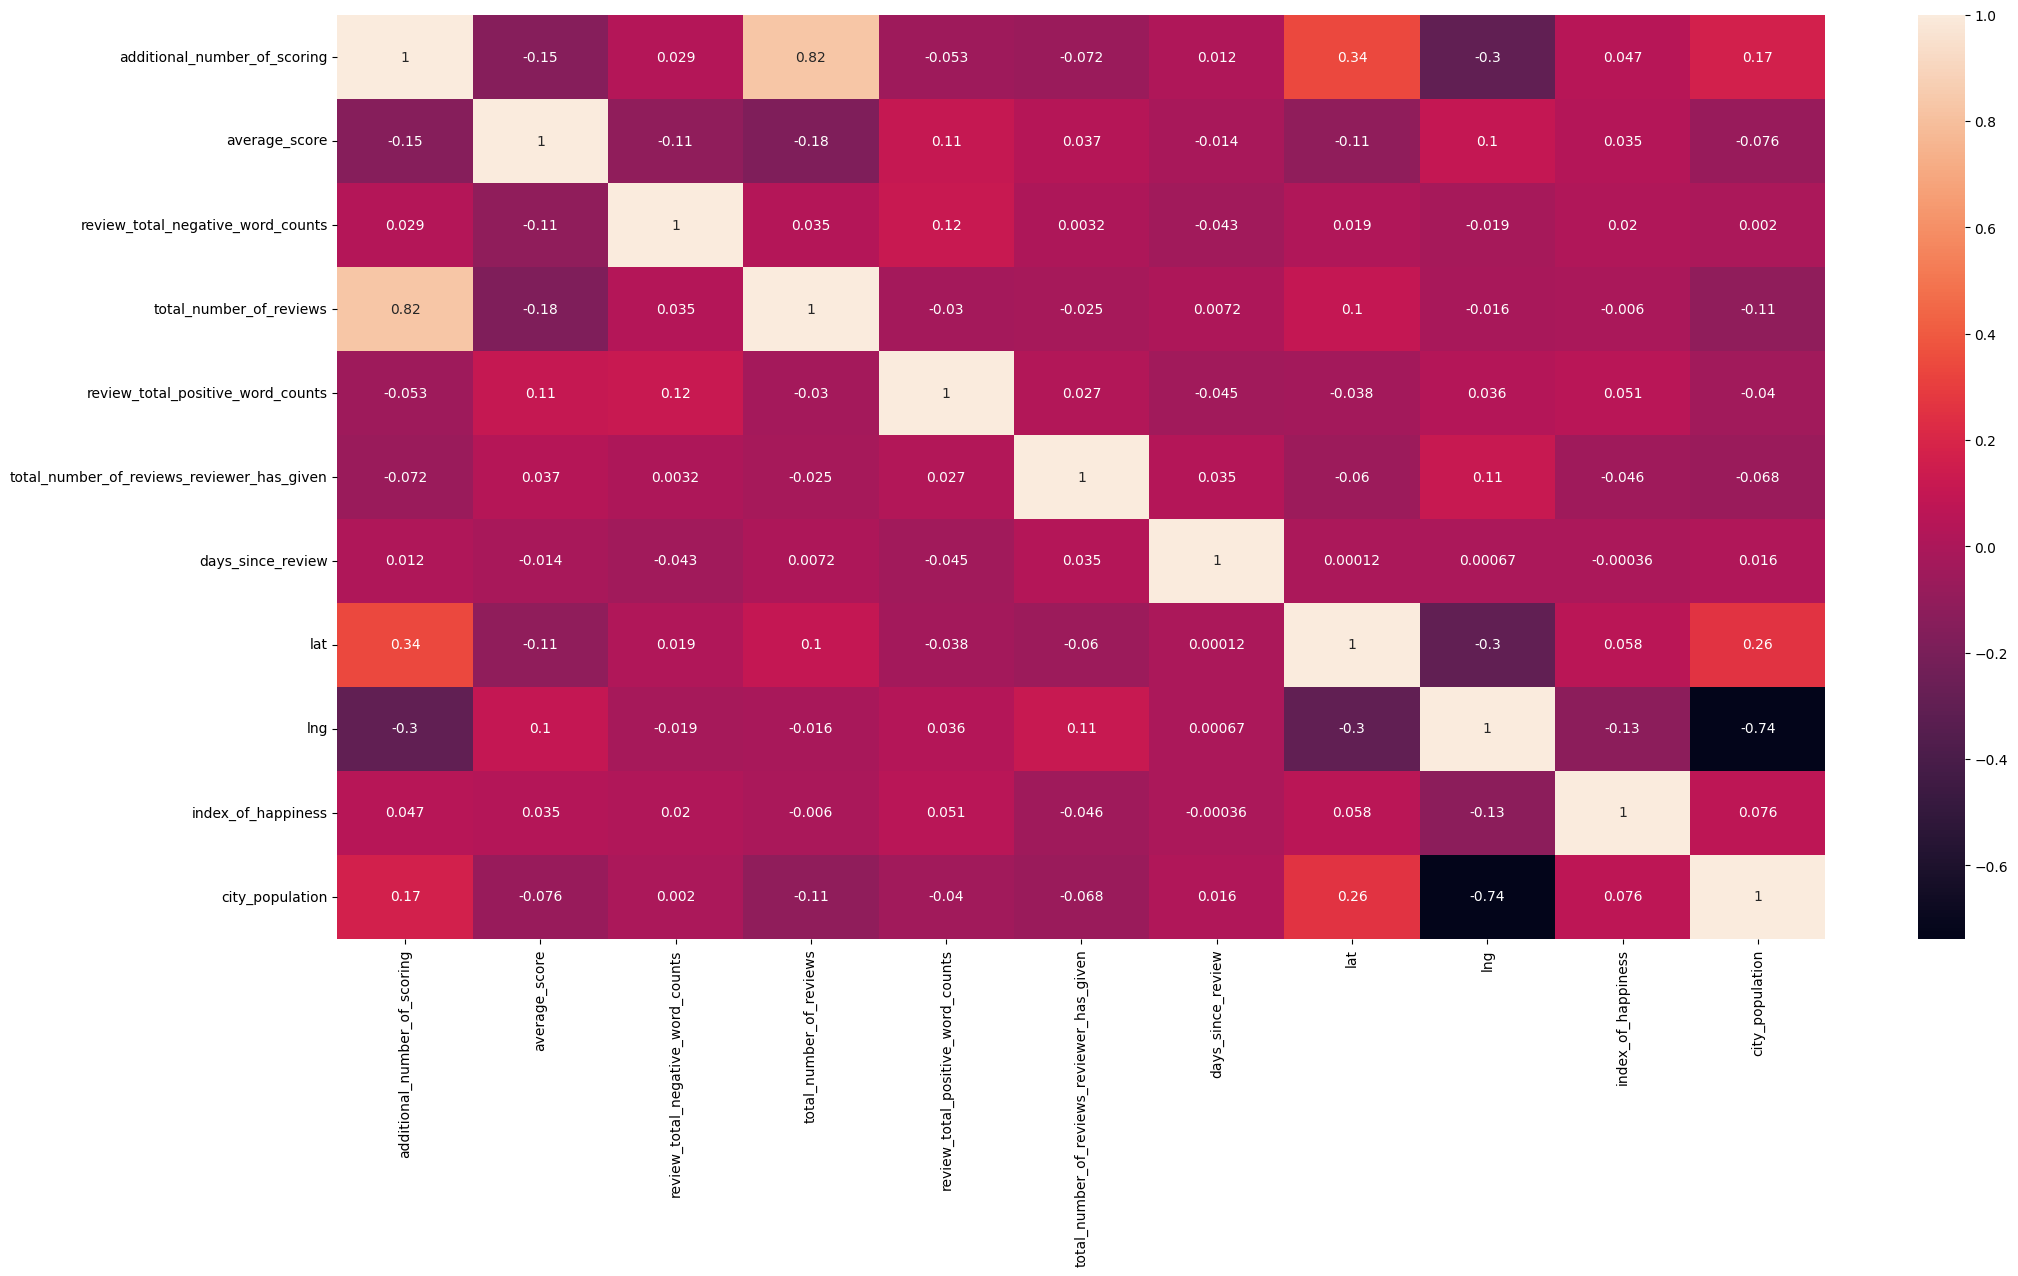

In [75]:
# Построим тепловую карту корреляции для числовых непрерывных значений
fig = plt.figure(figsize=(24, 12))
sns.heatmap(data.loc[:,num_cols].corr(method='pearson'), annot=True, fmt='.2g');

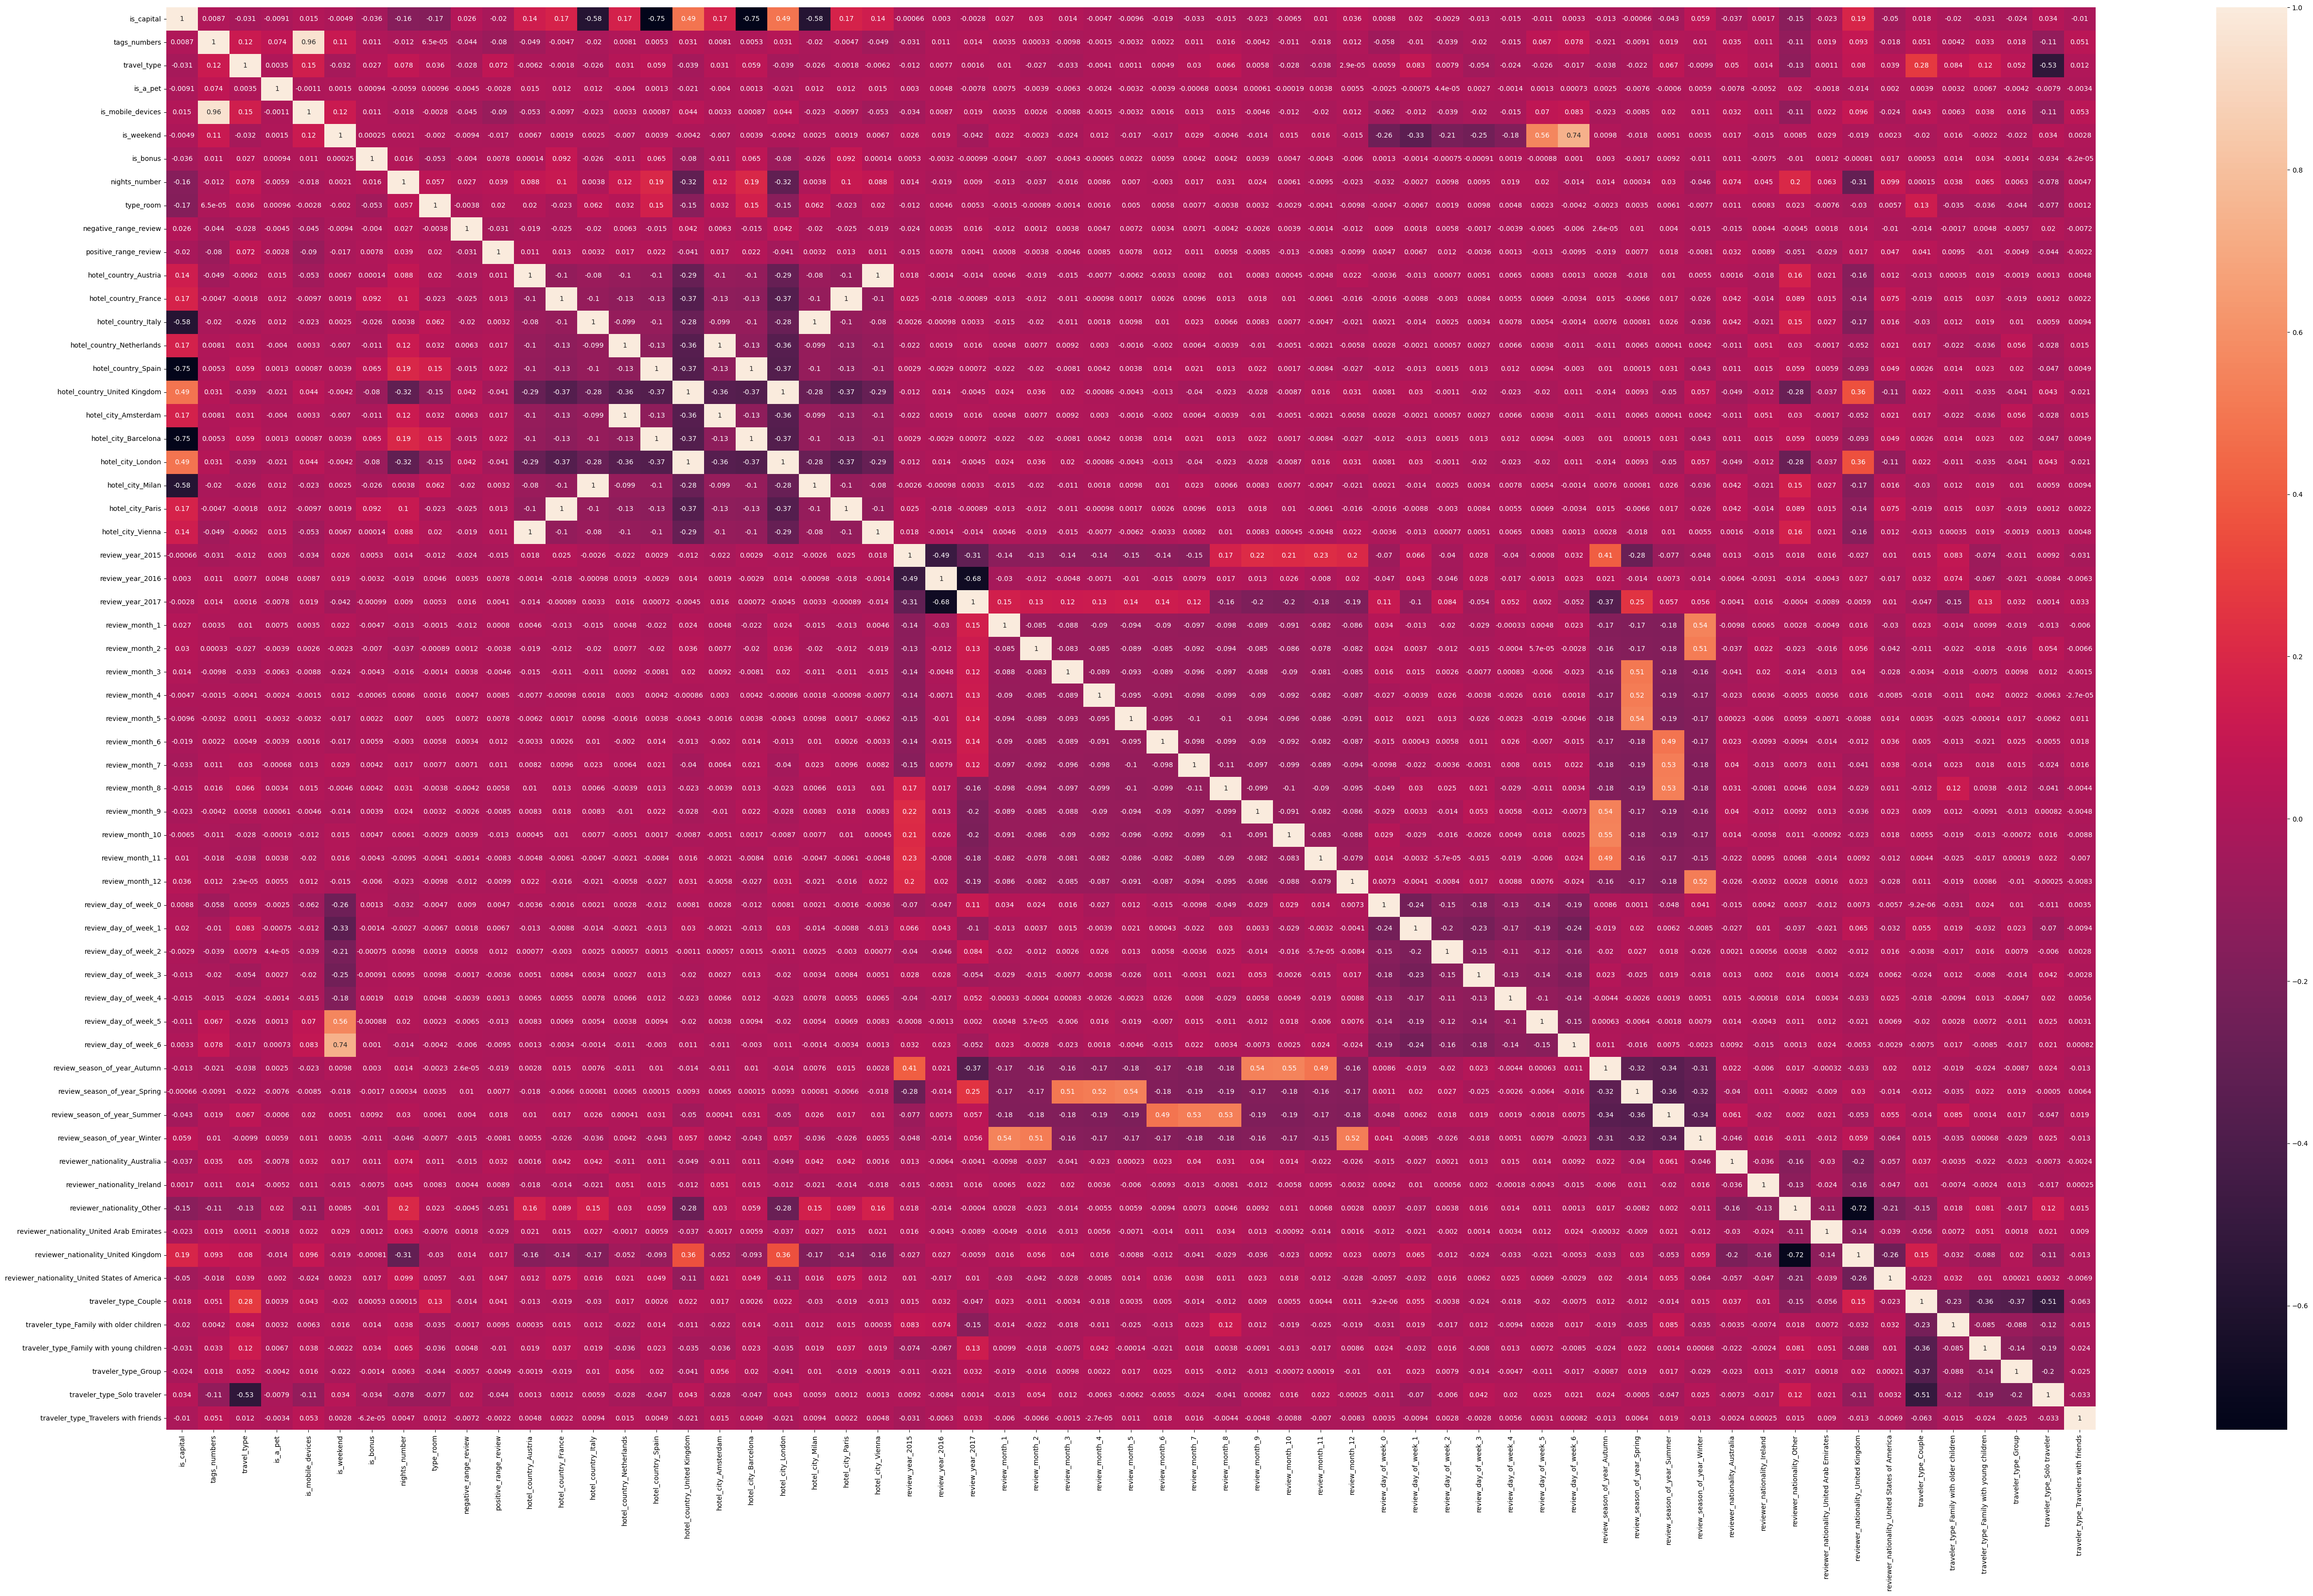

In [76]:
# Построим тепловую карту корреляции для категориальных значений
fig = plt.figure(figsize=(64, 38))
sns.heatmap(data.loc[:, cat_cols].corr(method='spearman'), annot=True, fmt='.2g');

In [77]:
# Удалим признаки, которые коррелируют между собой
data=data.drop(axis=1, columns=['additional_number_of_scoring','tags_numbers', 'hotel_country_Austria', 'hotel_country_France', 'hotel_country_Italy', 'hotel_country_Netherlands', 'hotel_country_Spain', 'hotel_country_United Kingdom', 'city_population', 'review_day_of_week_6', 'is_capital', 'reviewer_nationality_United Kingdom'])

## 5. Нормализация числовых признаков.

#### Прежде, чем нормализировать все числовые признаки необходимо удостовериться, что они не содержат выбросов. Для этого для всех цифровых непрырывных признаков строим гистограммы распределения и коробчатые диаграммы.

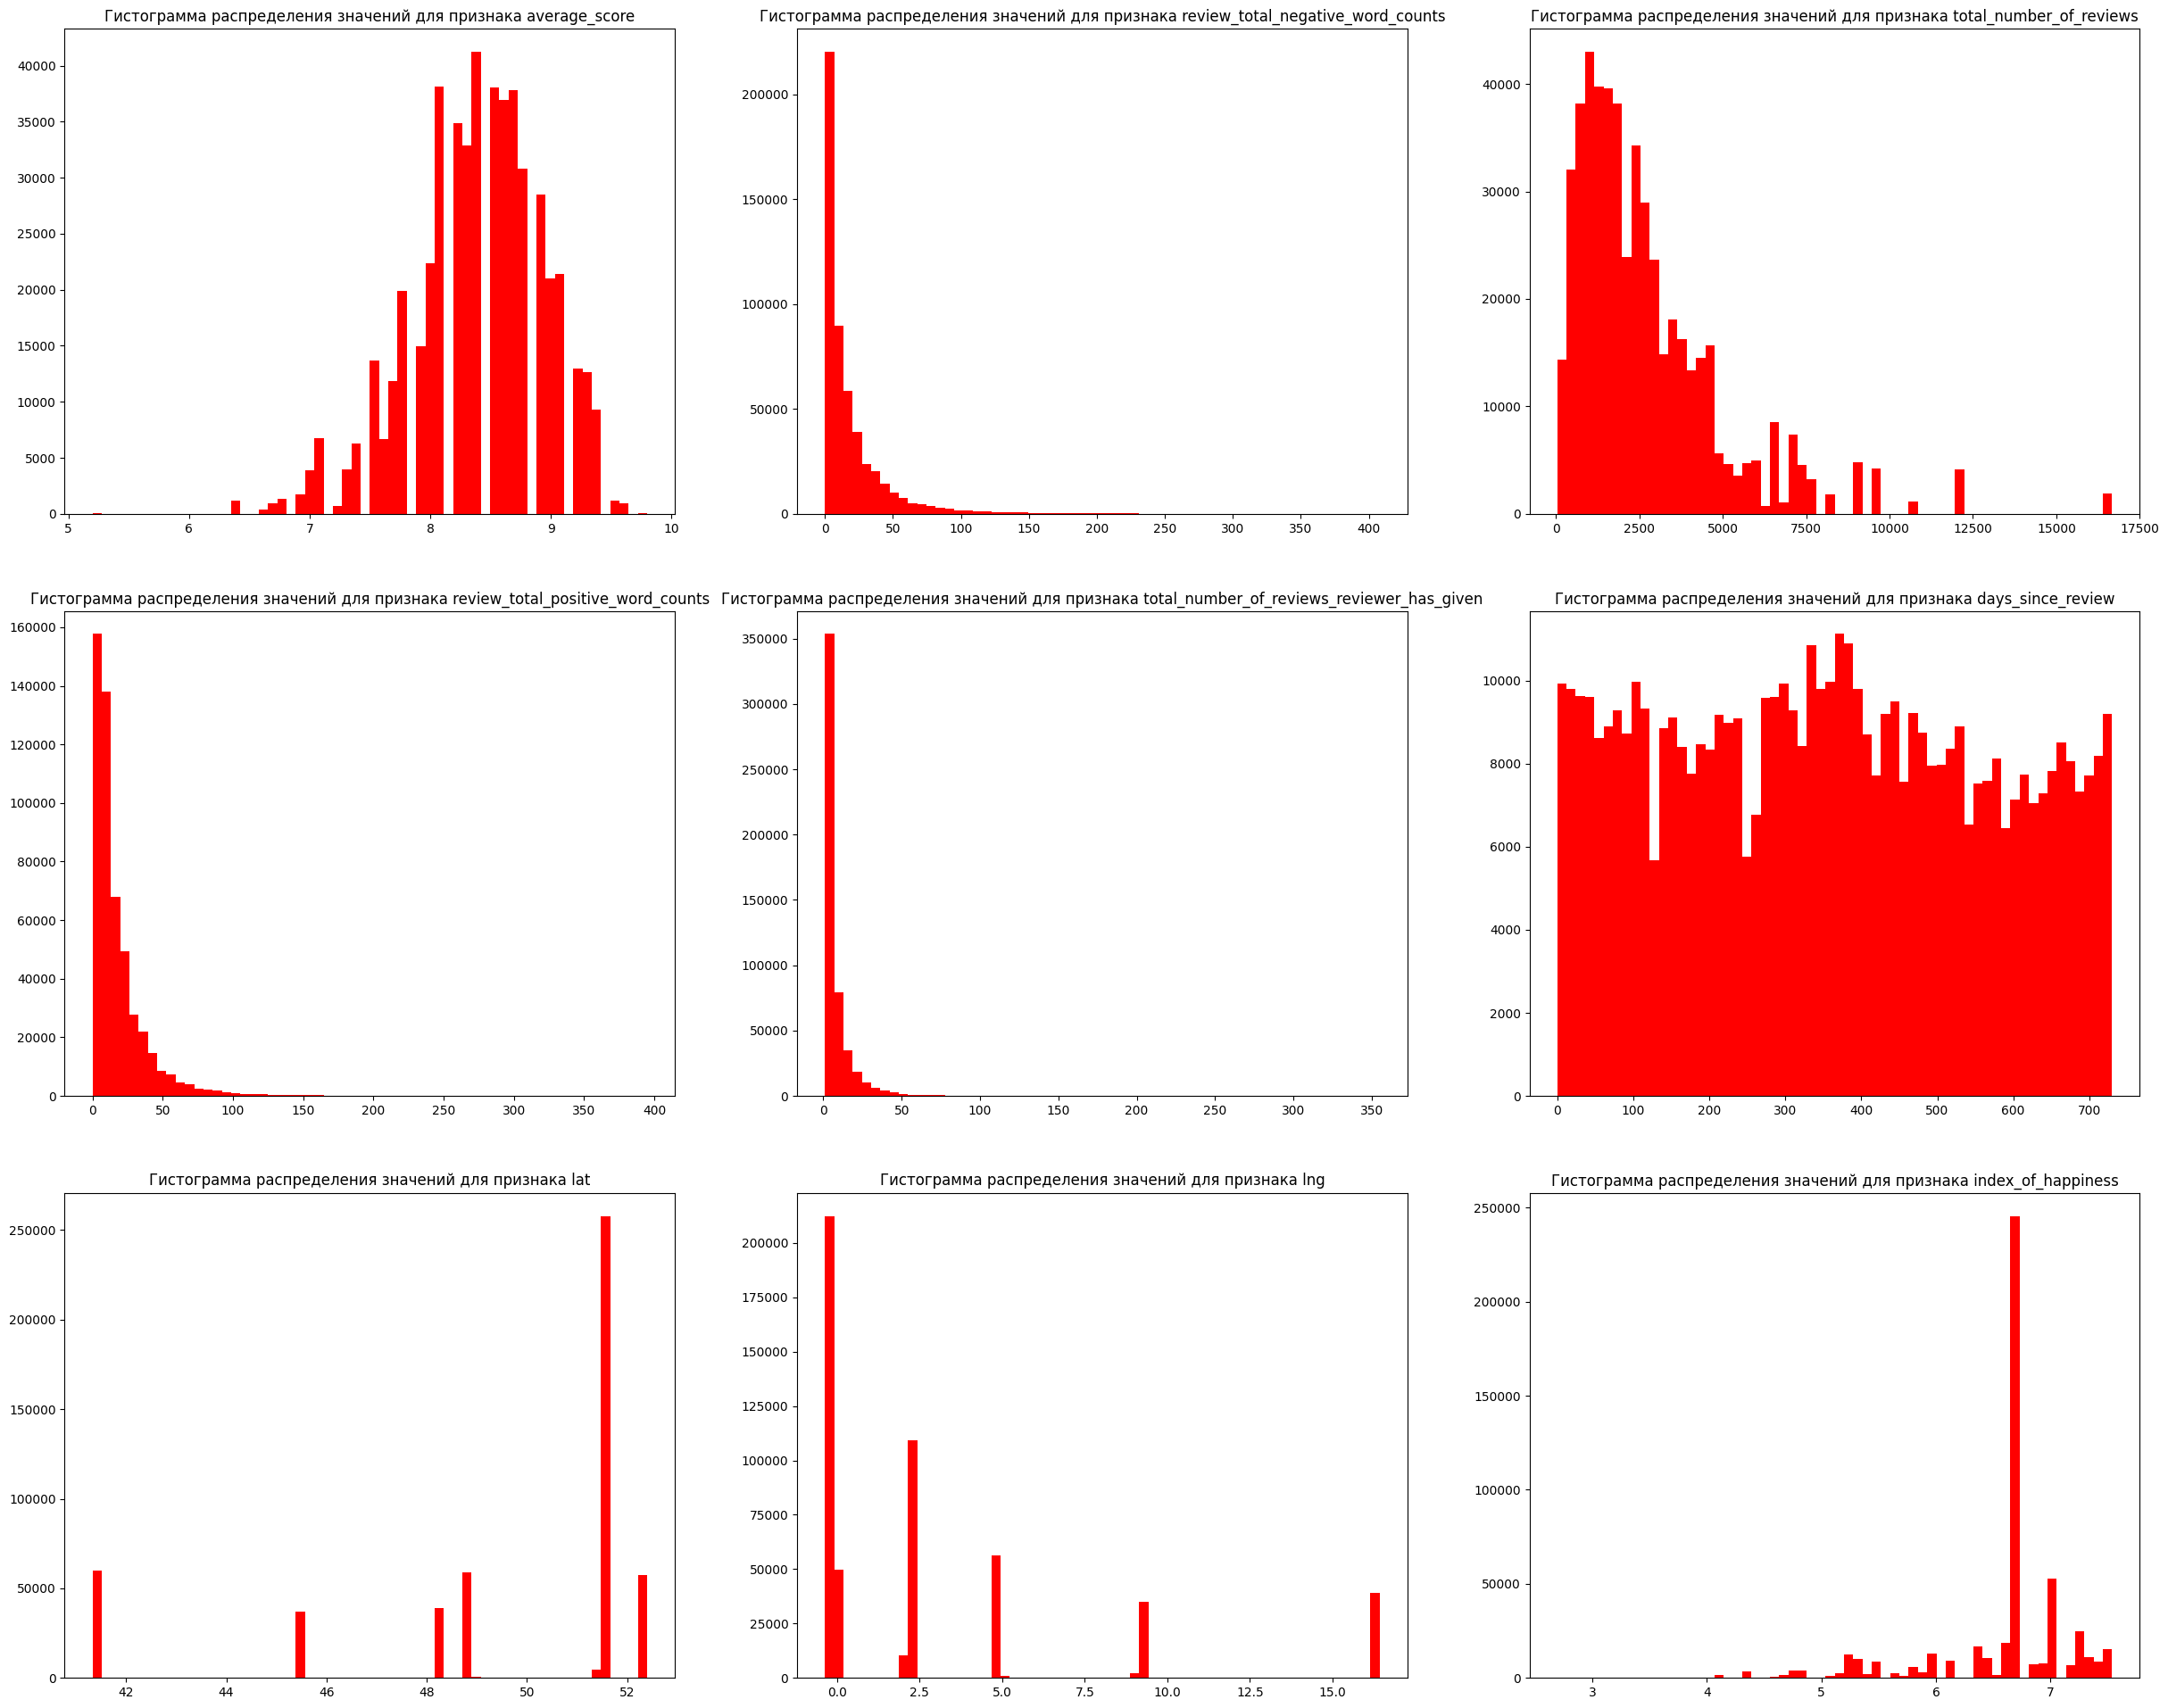

In [78]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(30, 24))

axes[0][0].hist(
    x=data["average_score"], color="red", bins=60
)
axes[0][0].set_title("Гистограмма распределения значений для признака average_score")


axes[0][1].hist(
    x=data["review_total_negative_word_counts"], color="red", bins=60
)
axes[0][1].set_title("Гистограмма распределения значений для признака review_total_negative_word_counts")


axes[0][2].hist(
    x=data["total_number_of_reviews"], color="red", bins=60
)
axes[0][2].set_title("Гистограмма распределения значений для признака total_number_of_reviews")


axes[1][0].hist(
    x=data["review_total_positive_word_counts"], color="red", bins=60
)
axes[1][0].set_title("Гистограмма распределения значений для признака review_total_positive_word_counts")


axes[1][1].hist(
    x=data["total_number_of_reviews_reviewer_has_given"], color="red", bins=60
)
axes[1][1].set_title("Гистограмма распределения значений для признака total_number_of_reviews_reviewer_has_given")


axes[1][2].hist(
    x=data["days_since_review"], color="red", bins=60
)
axes[1][2].set_title("Гистограмма распределения значений для признака days_since_review")


axes[2][0].hist(
    x=data["lat"], color="red", bins=60
)
axes[2][0].set_title("Гистограмма распределения значений для признака lat")


axes[2][1].hist(
    x=data["lng"], color="red", bins=60
)
axes[2][1].set_title("Гистограмма распределения значений для признака lng")


axes[2][2].hist(
    x=data["index_of_happiness"], color="red", bins=60
)
axes[2][2].set_title("Гистограмма распределения значений для признака index_of_happiness");


#### Как видно из гистограммам лишь три признака могут содержать выбросы: total_number_of_reviews_reviewer_has_given, review_total_positive_word_counts, review_total_negative_word_counts. Построим коробчатые диаграммы, что проверить это. 

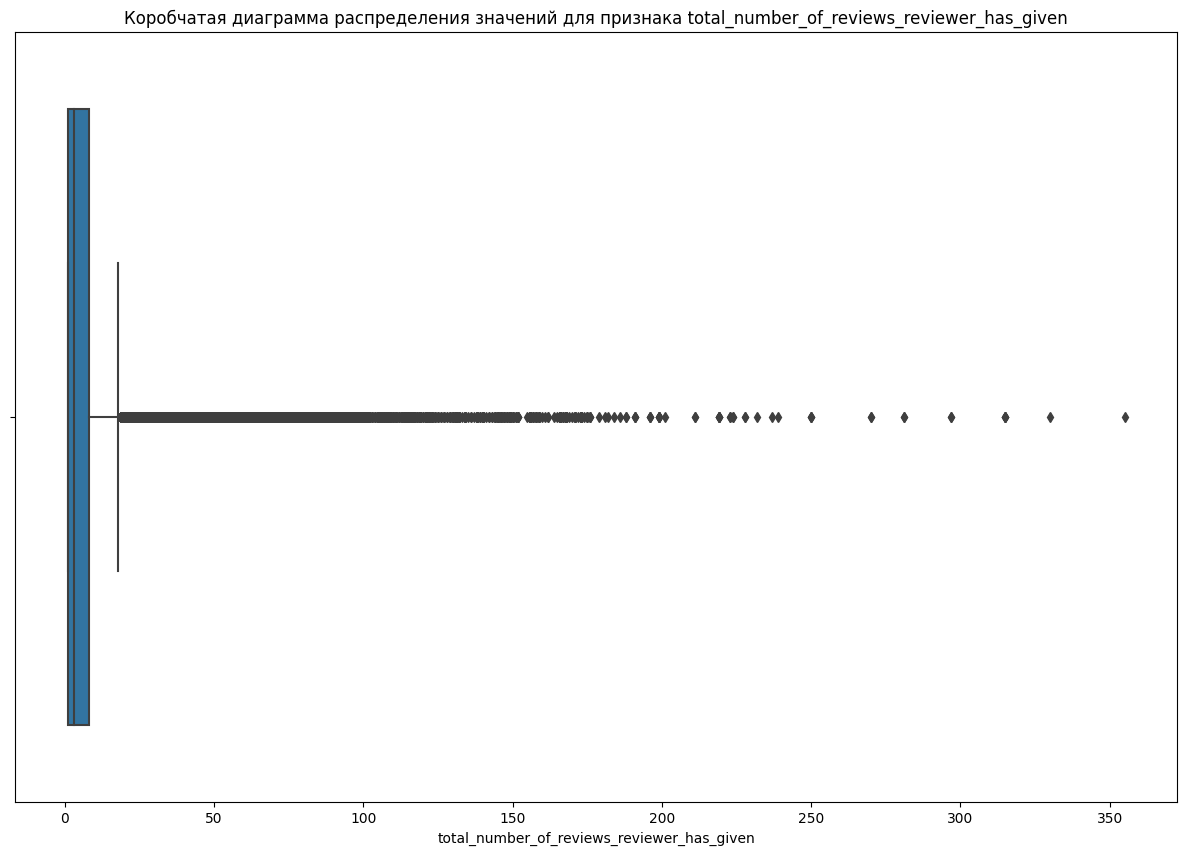

In [79]:
boxplot = sns.boxplot(data=data, x='total_number_of_reviews_reviewer_has_given');
boxplot.set_title('Коробчатая диаграмма распределения значений для признака total_number_of_reviews_reviewer_has_given');

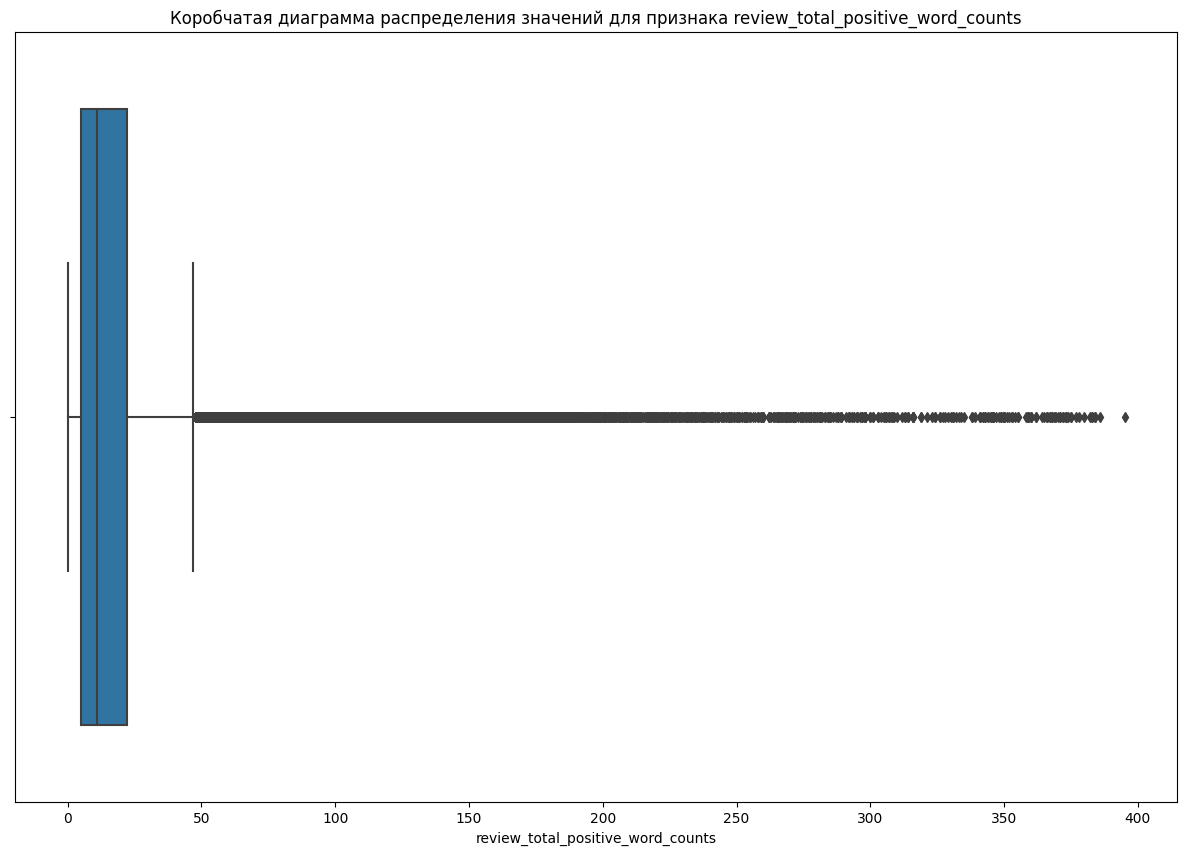

In [80]:
boxplot = sns.boxplot(data=data, x='review_total_positive_word_counts');
boxplot.set_title('Коробчатая диаграмма распределения значений для признака review_total_positive_word_counts');

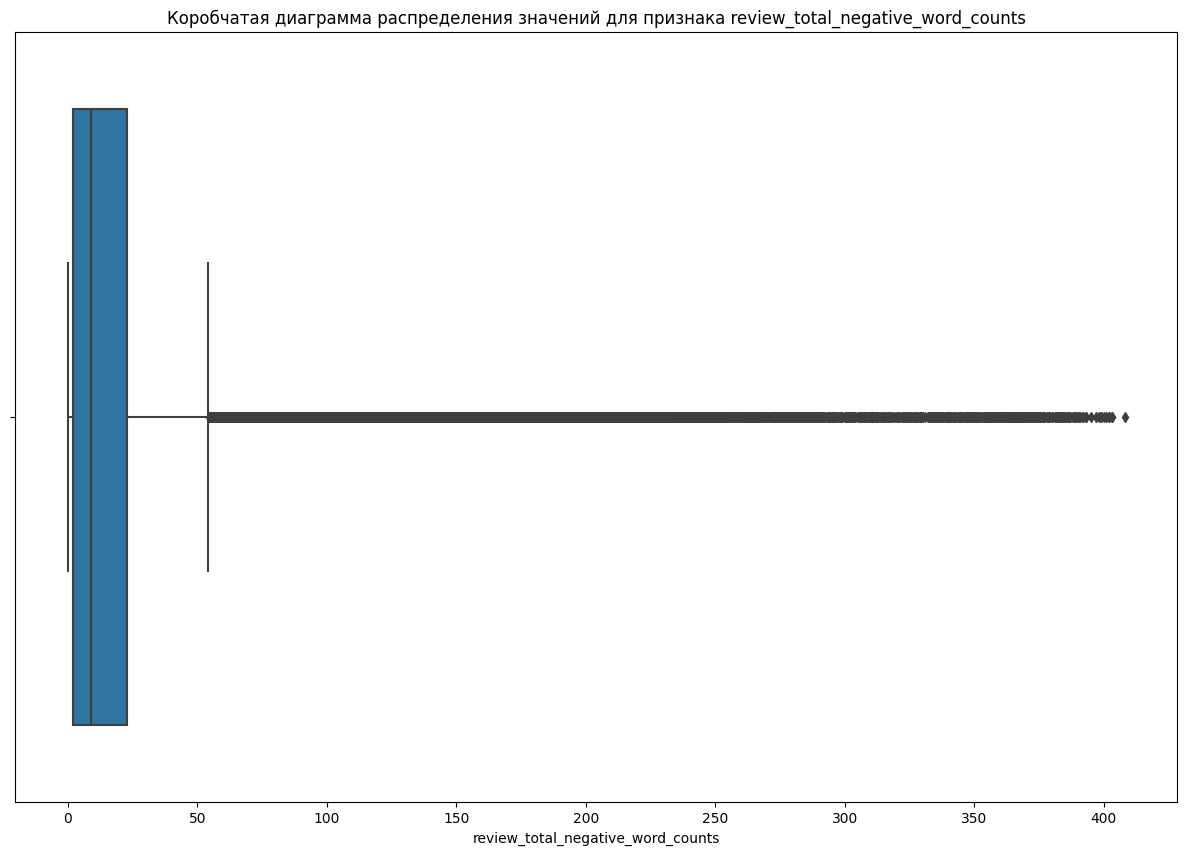

In [81]:
boxplot = sns.boxplot(data=data, x='review_total_negative_word_counts');
boxplot.set_title('Коробчатая диаграмма распределения значений для признака review_total_negative_word_counts');

#### Как видно из коробчатых диаграмм выбросов в распределениях не существует. Следовательно можем нормализировать все непрырывные числовые признаки методом MinMaxScaler.

In [82]:
# Для нормализации, стандартизации подключим библиотеку
from sklearn import preprocessing

# Инициализируем нормализатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()

# фиксация названий столбцов
cols = ['average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'days_since_review', 'lat', 'lng', 'index_of_happiness']

# кодируем исходный датасет
scaled = scaler.fit_transform(data[cols])

# Преобразуем промежуточный датасет в полноценный датафрейм
data_sc = pd.DataFrame(scaled, columns=cols)

# Добавим нормализированный датафрейм к основному дата-фрейму data
data = pd.concat([data_sc, data.drop(axis=1, columns=cols)], axis=1)

In [83]:
# Переопределим непрерывные числовые признаки
num_cols = list(data.columns)[:9]

# Переопределим категориальные признаки
cat_cols = list(data.columns)[11:]

In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 62 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   average_score                                  515431 non-null  float64
 1   review_total_negative_word_counts              515431 non-null  float64
 2   total_number_of_reviews                        515431 non-null  float64
 3   review_total_positive_word_counts              515431 non-null  float64
 4   total_number_of_reviews_reviewer_has_given     515431 non-null  float64
 5   days_since_review                              515431 non-null  float64
 6   lat                                            515431 non-null  float64
 7   lng                                            515431 non-null  float64
 8   index_of_happiness                             515431 non-null  float64
 9   reviewer_score                       

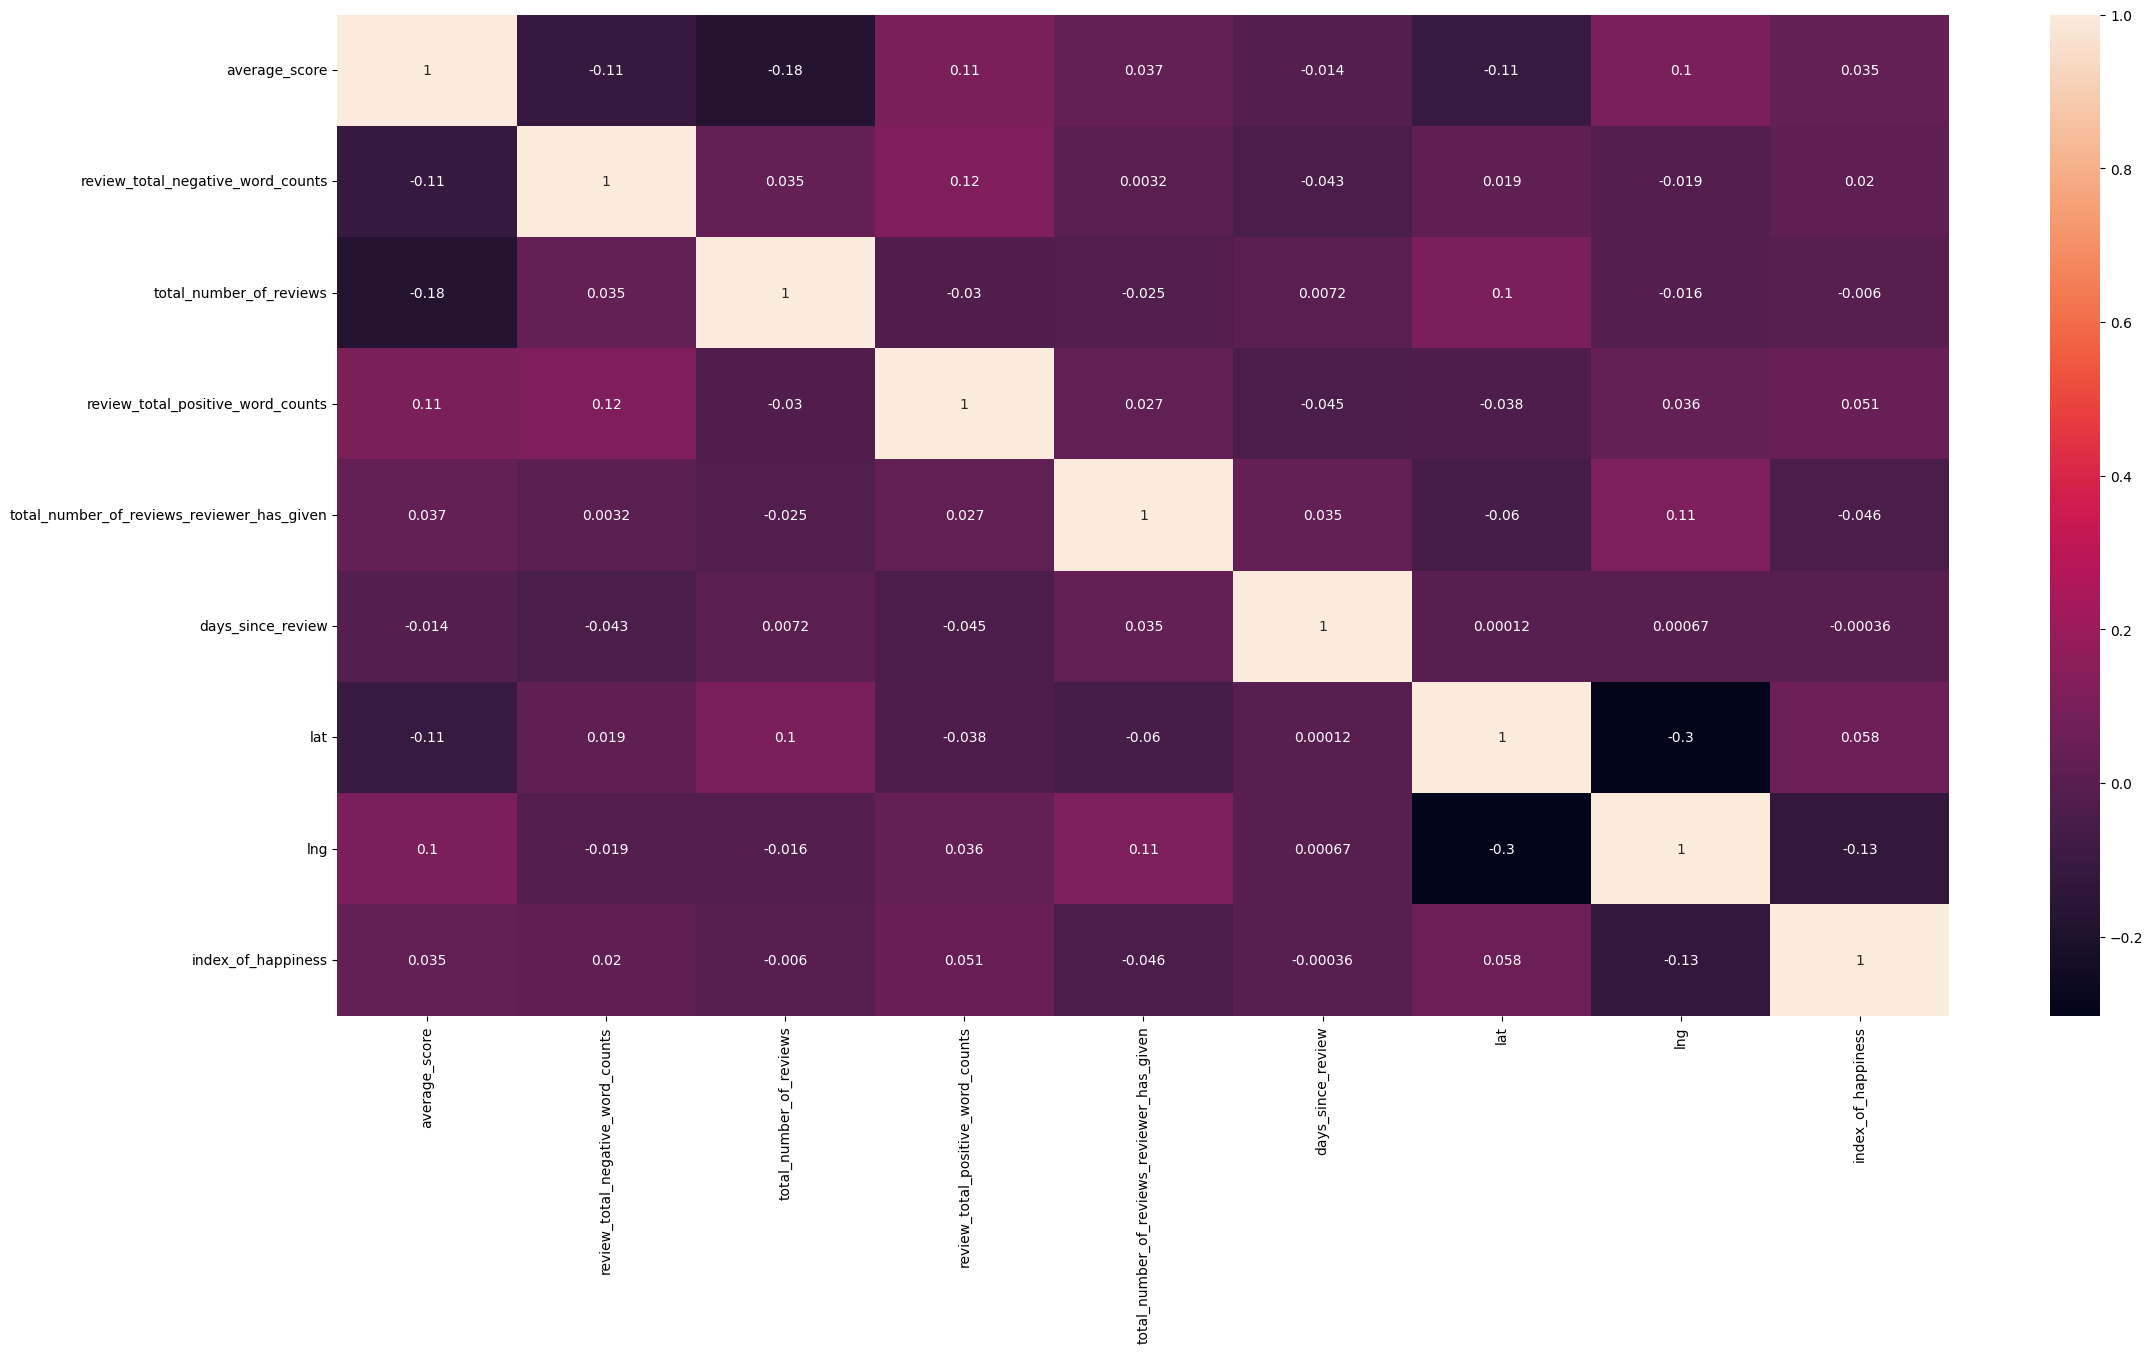

In [85]:
# Построим еще раз тепловую карту корреляции для числовых признаков и убедимся, что все прошло хорошо
fig = plt.figure(figsize=(26, 13))
sns.heatmap(data.loc[:,num_cols].corr(method='pearson'), annot=True, fmt='.2g');

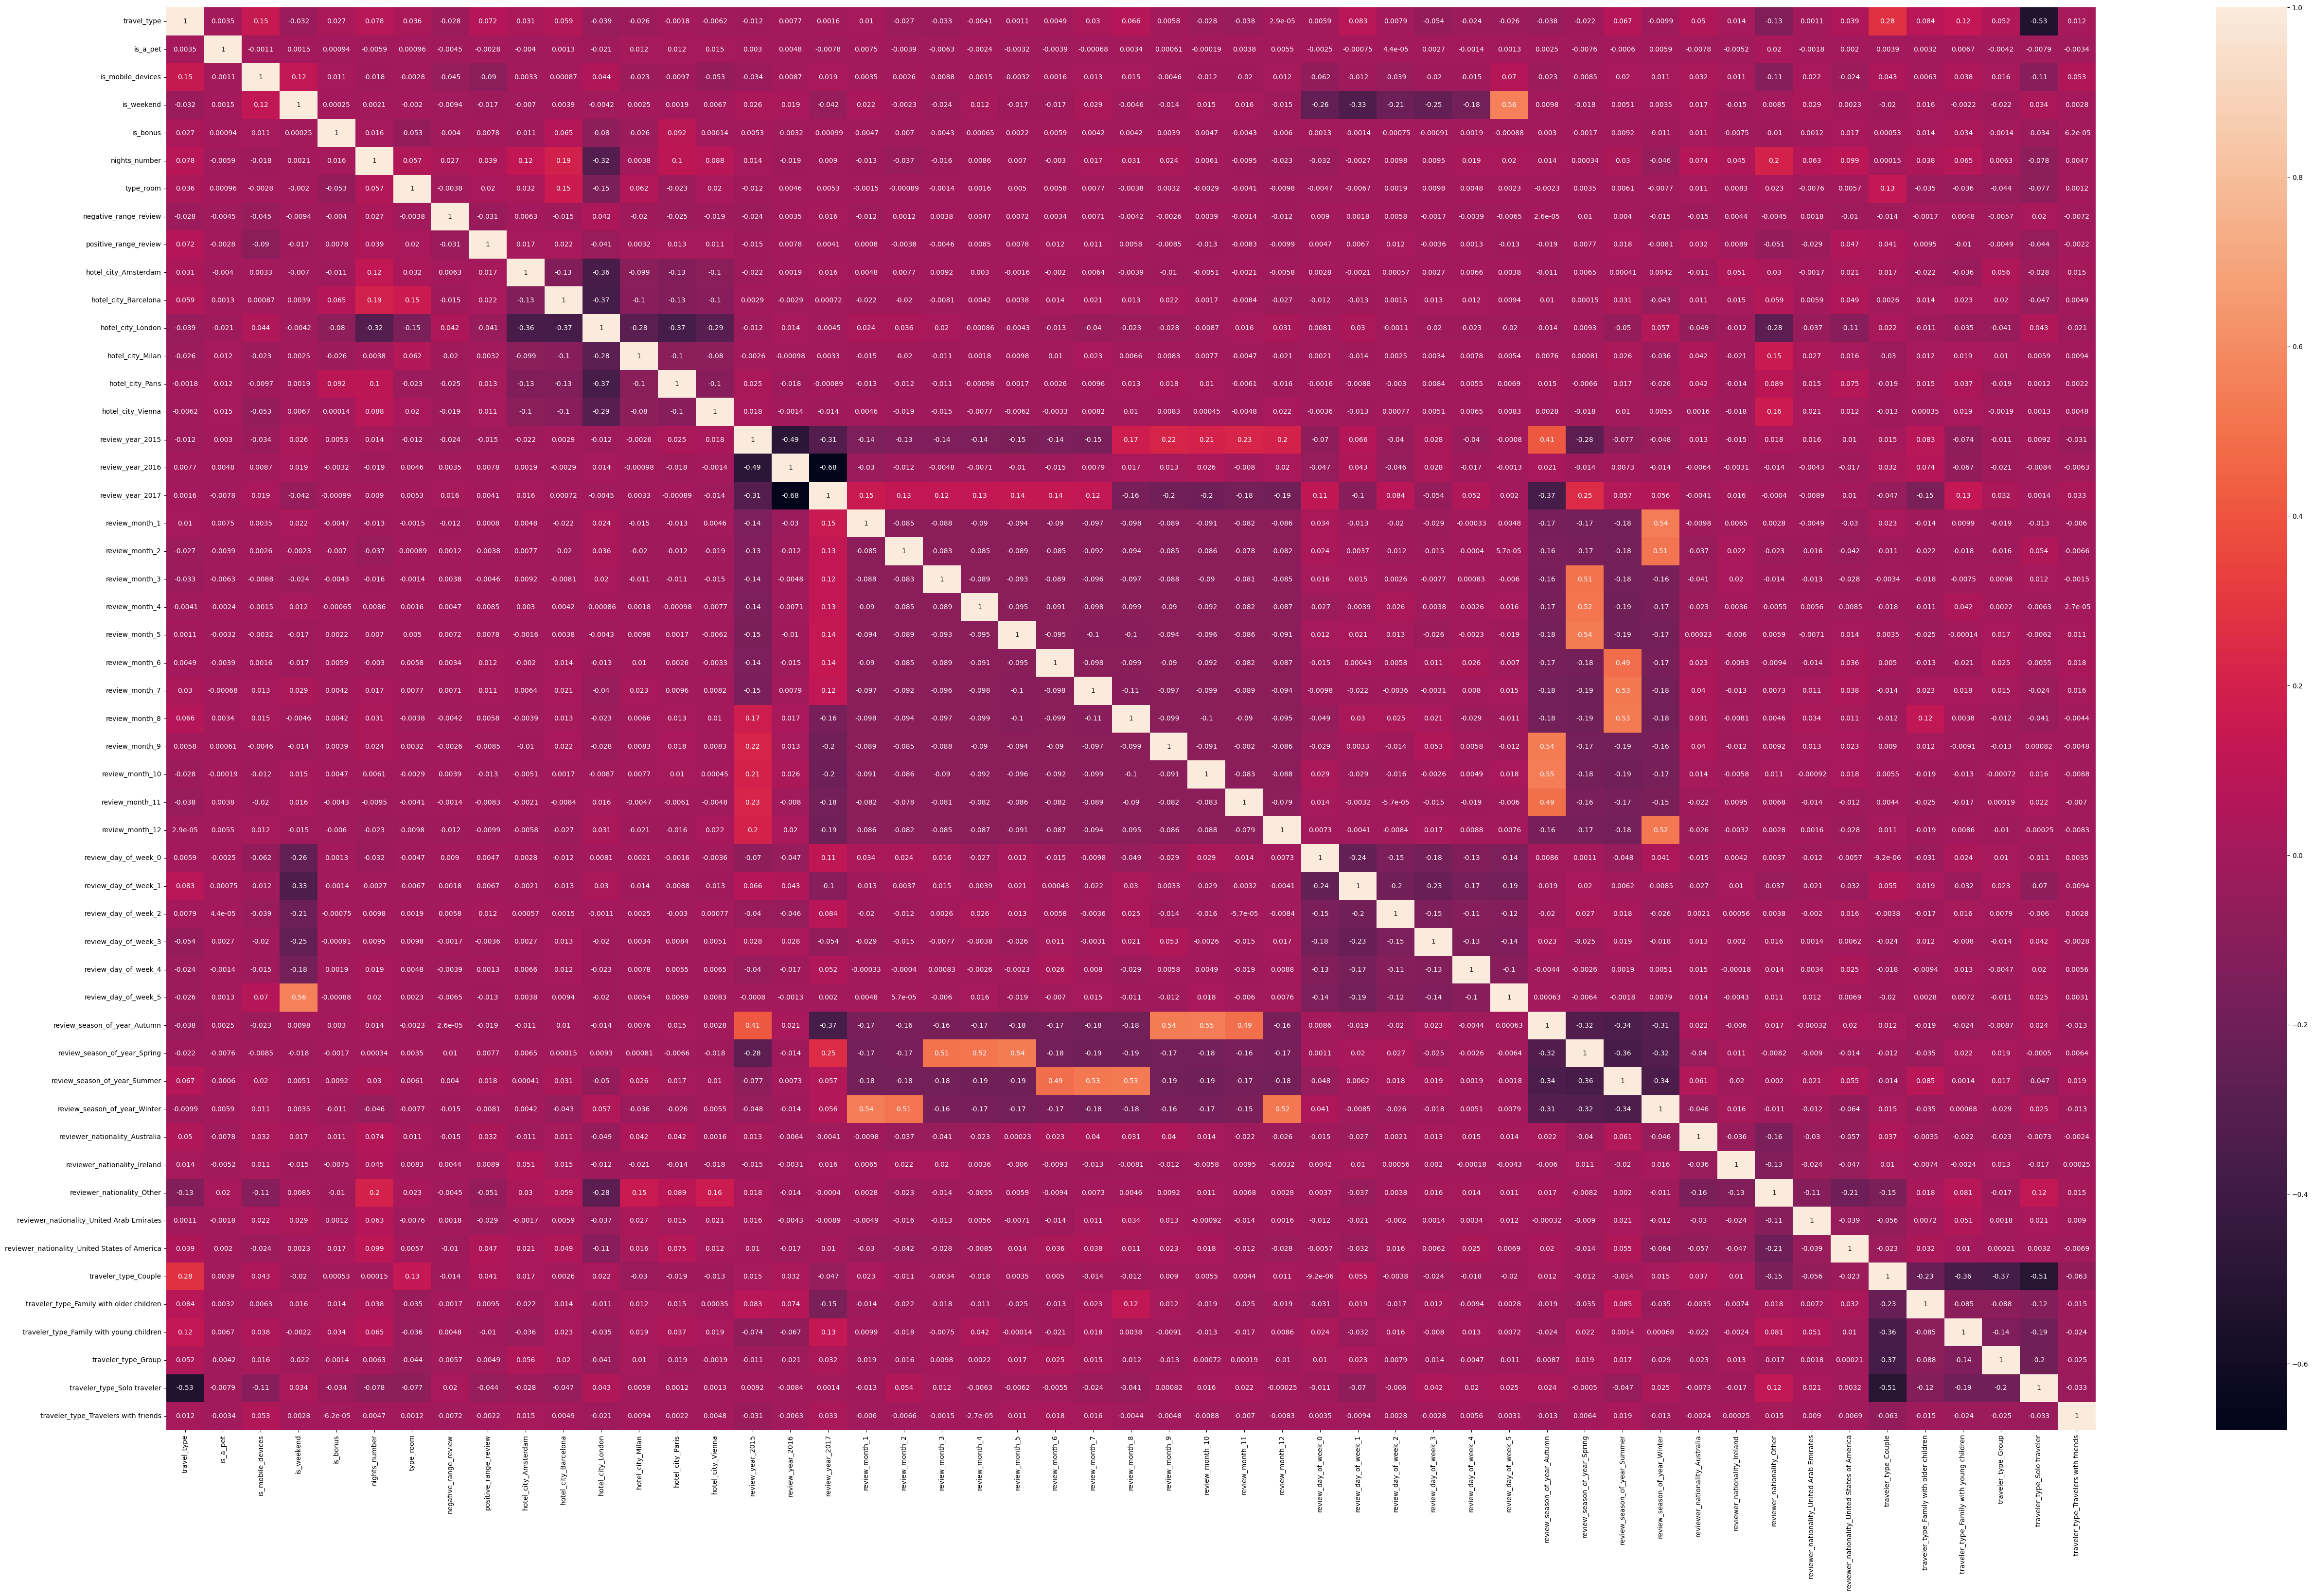

In [86]:
# Построим еще раз тепловую карту корреляции для категориальных признаков, чтобы проверить нет ли еще мультиколлинеарных признаков
fig = plt.figure(figsize=(64, 38))
sns.heatmap(data.loc[:, cat_cols].corr(method='spearman'), annot=True, fmt='.2g');

## 6. Отбор признаков.

In [87]:
# Теперь выделим тестовую часть выборки
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # Наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

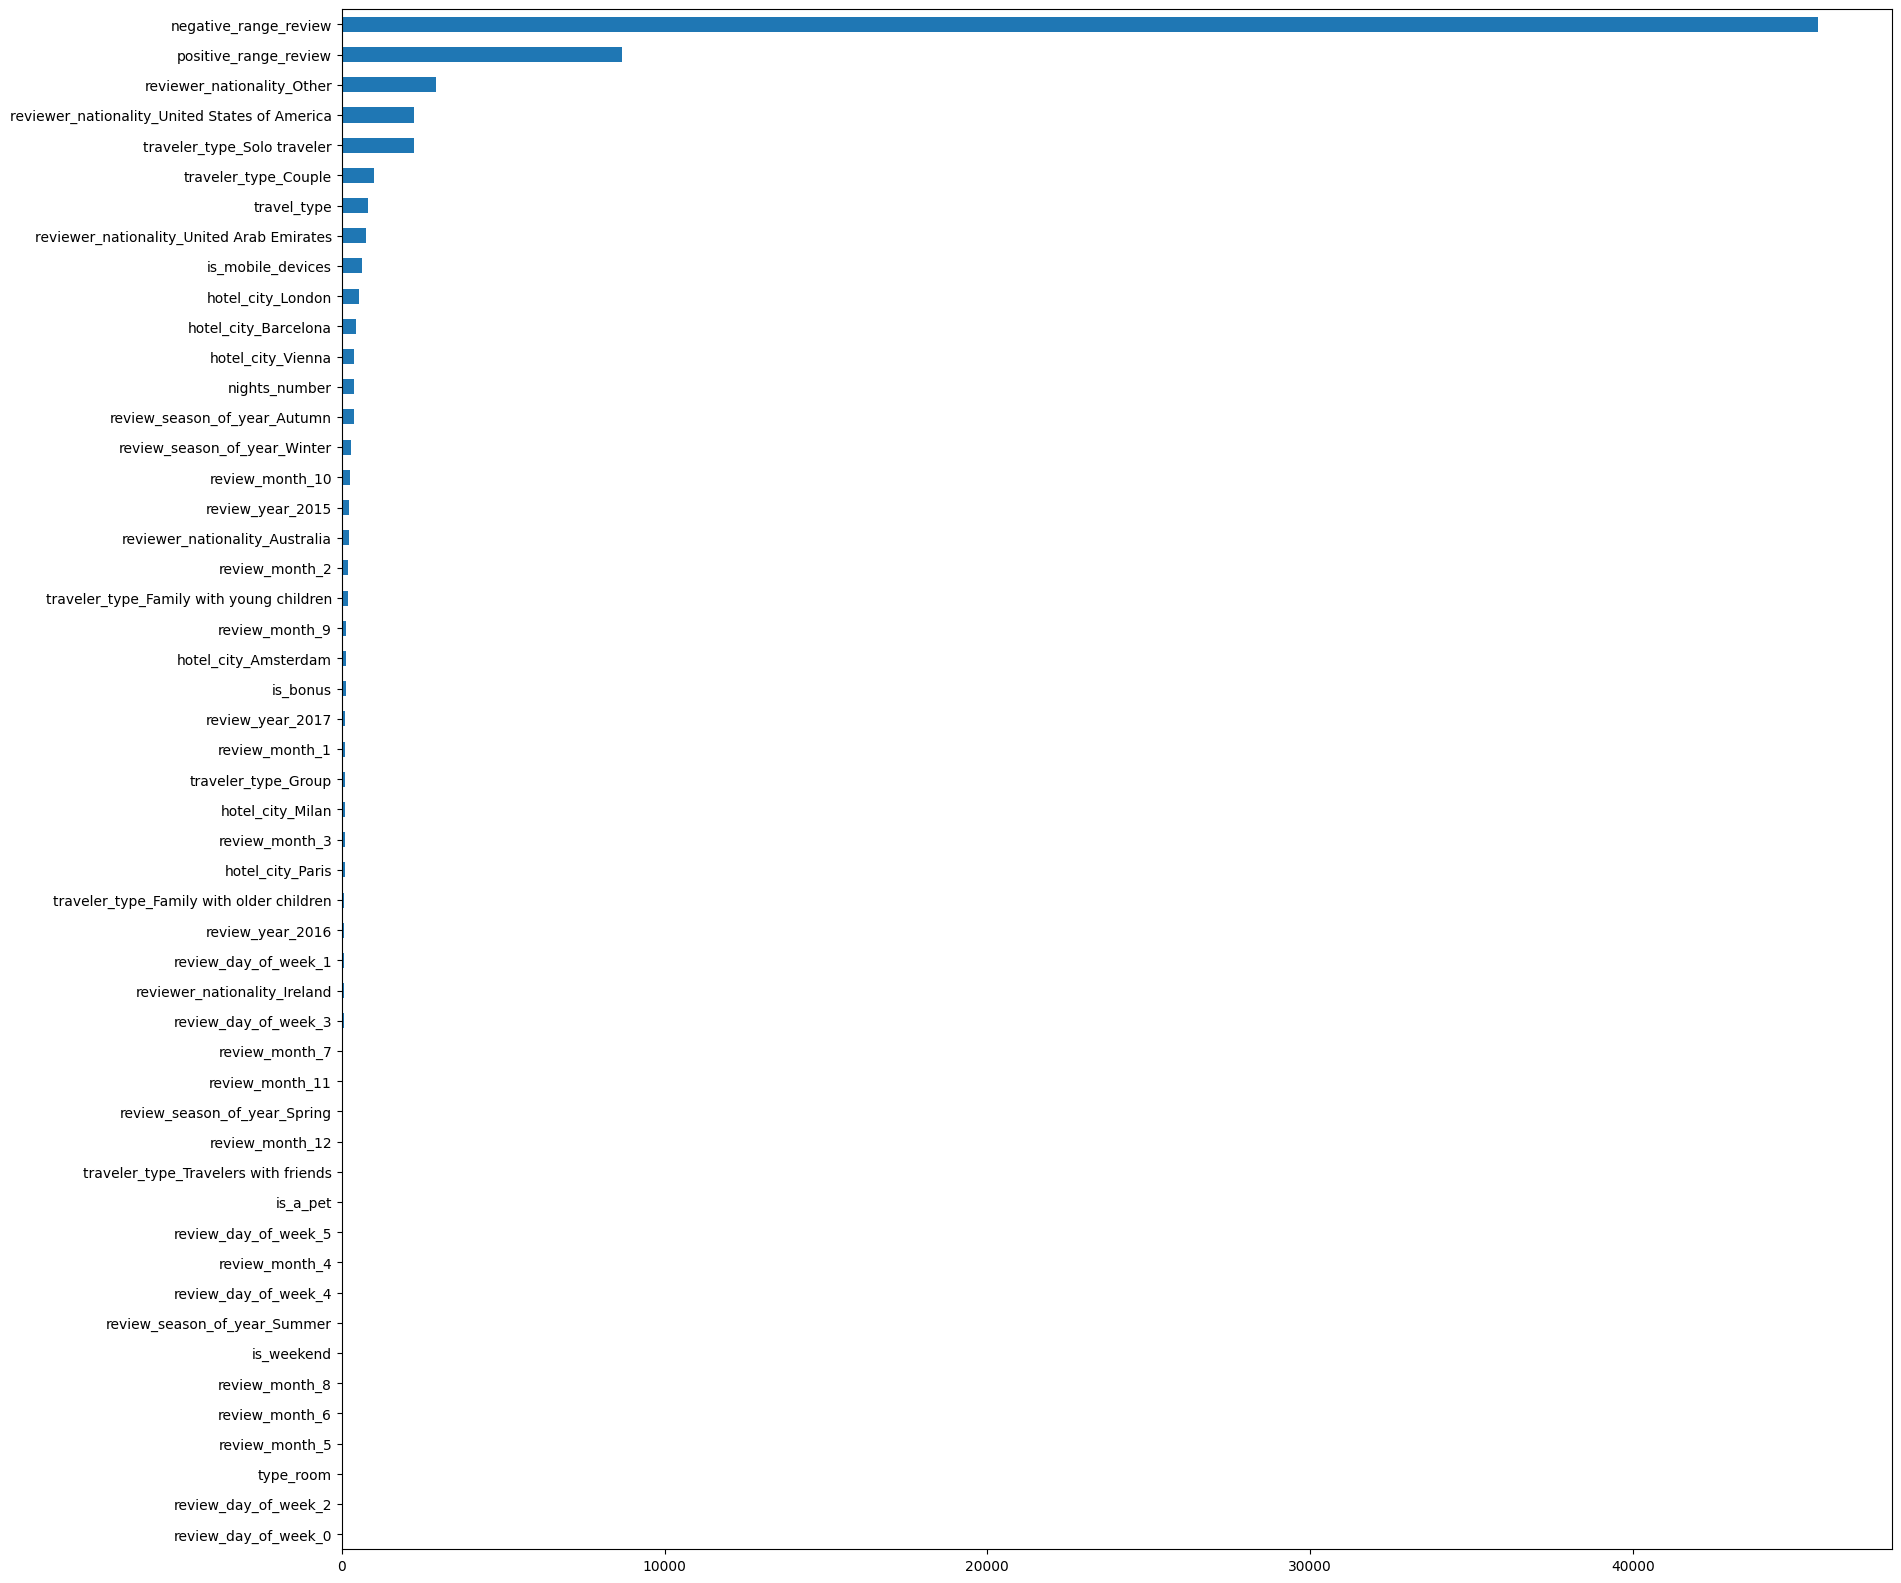

In [88]:
# Проведем тест на значимость категориальных признаков
y=y.astype('int')

from sklearn.feature_selection import chi2 # Импортируем тест хи-квадрат

plt.rcParams['figure.figsize'] = (20,20)
imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

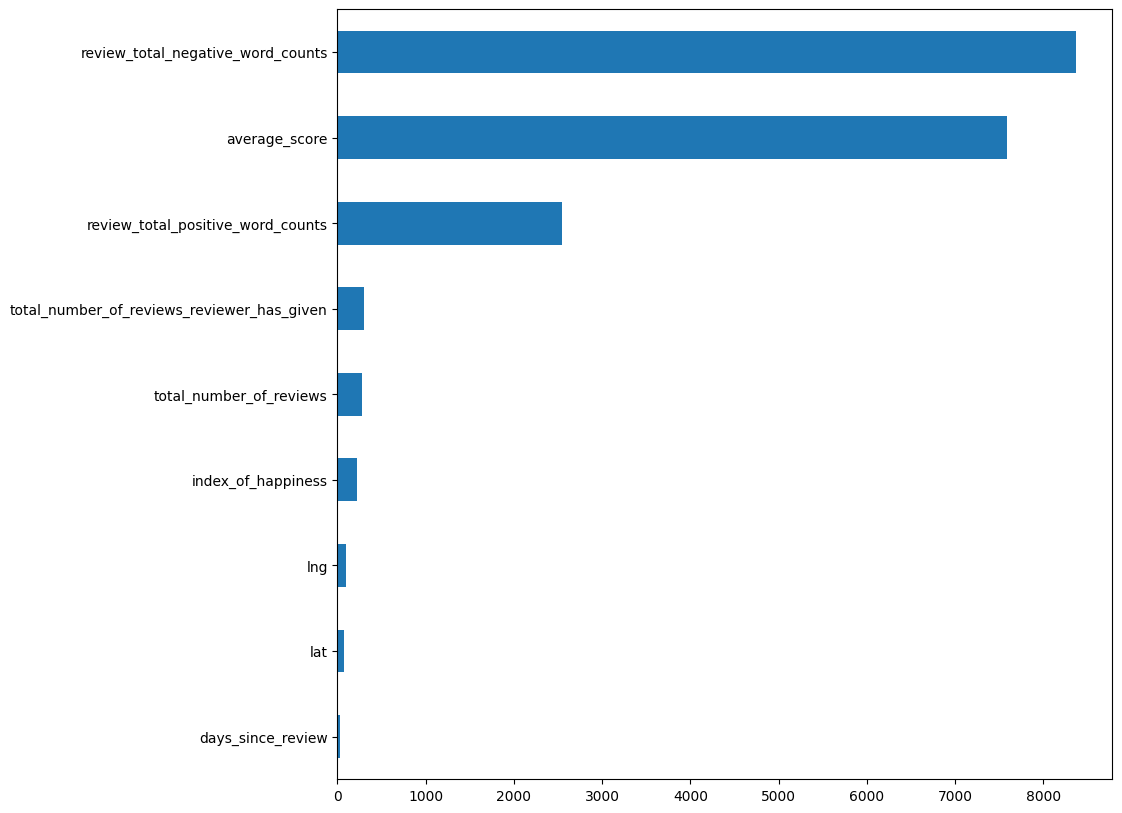

In [89]:
# Проведем тест на значимость непрерывных признаков
from sklearn.feature_selection import f_classif # Импортируем тест anova
plt.rcParams['figure.figsize'] = (10,10)
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

#### Проведя исследования на значительность категориальных и цифровых признаков, а также методом перебора при припоследовательном удалении многих малозначительных признаков, я пришел к выводу, что наилучший результат MAPE модели дает удаление самого малозначительного категориального признака "review_day_of_week_0".

In [90]:
train_data = train_data.drop(columns=list(imp_cat.index)[0], axis=1) # Удалим самый малозначительный категориальный признак из модели
test_data = test_data.drop(columns=list(imp_cat.index)[0], axis=1) # Удалим самый малозначительный категориальный признак из модели

y = train_data.reviewer_score.values # Переопределяем наш таргет
X = train_data.drop(['reviewer_score'], axis=1) # Переопределяем значение для X

## 7. Построение модели.

In [91]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [92]:
# Проверяем размерность
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 60), (386496, 60), (386496, 59), (309196, 59), (77300, 59))

In [93]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [94]:
# Создаём модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [95]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


In [96]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test).
# Метрика называется Mean Absolute Percentage Error (MAPE).
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13281690595040532


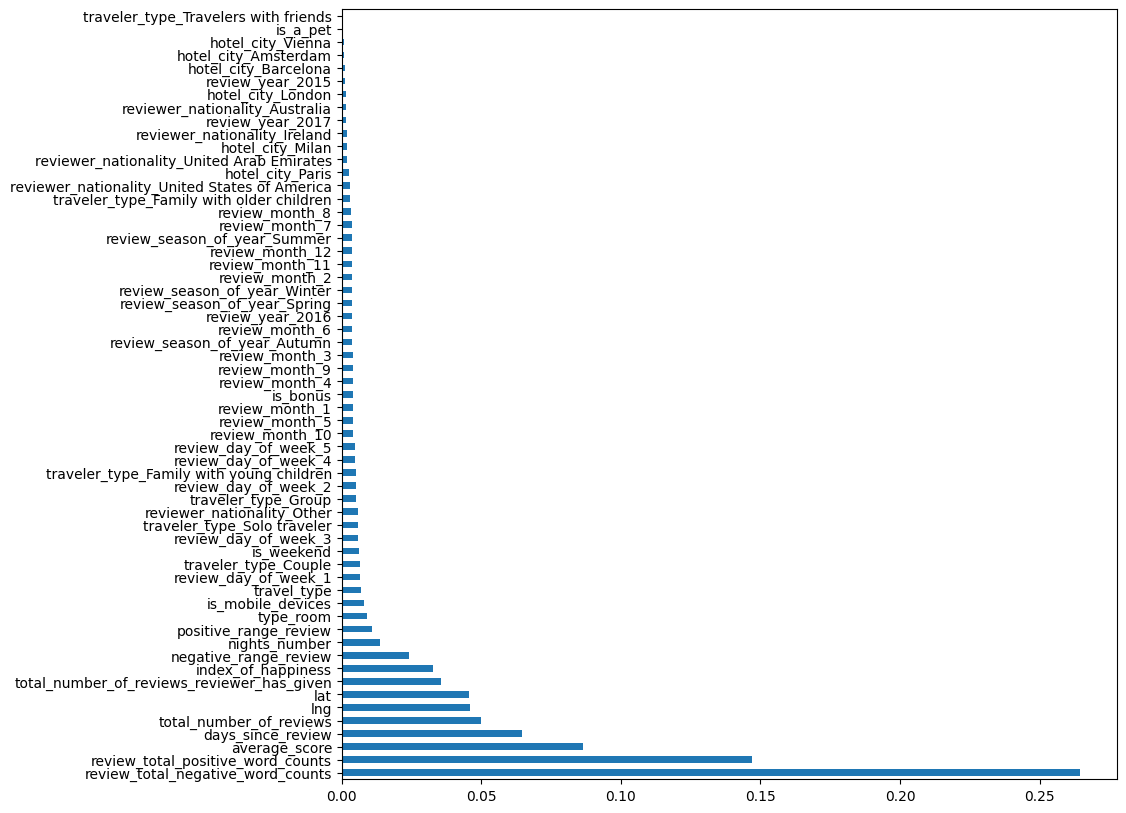

In [97]:
# В RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(list(X.columns))).plot(kind='barh');

In [98]:
test_data.sample(10)

average_score  review_total_negative_word_counts  \
403102       0.739130                           0.017157   
466237       0.695652                           0.024510   
406450       0.782609                           0.017157   
487619       0.673913                           0.014706   
437738       0.260870                           0.095588   
497895       0.565217                           0.039216   
448220       0.695652                           0.041667   
500122       0.543478                           0.041667   
500041       0.673913                           0.022059   
418492       0.717391                           0.017157   

        total_number_of_reviews  review_total_positive_word_counts  \
403102                 0.140434                           0.027848   
466237                 0.085945                           0.017722   
406450                 0.077825                           0.000000   
487619                 0.206050                           0.025316   
437738                 0.134239                           0.070886   
497895                 0.354965                           0.007595   
448220                 0.232634                           0.159494   
500122                 0.260841                           0.020253   
500041                 0.013953                           0.017722   
418492                 0.171889                           0.020253   

        total_number_of_reviews_reviewer_has_given  days_since_review  \
403102                                    0.000000           0.209589   
466237                                    0.000000           0.368493   
406450                                    0.011299           0.005479   
487619                                    0.011299           0.441096   
437738                                    0.002825           0.513699   
497895                                    0.000000           0.108219   
448220                                    0.008475           0.861644   
500122                                    0.002825           0.984932   
500041                                    0.000000           0.805479   
418492                                    0.011299           0.023288   

             lat       lng  index_of_happiness  reviewer_score  ...  \
403102  0.620844  0.996768            0.773947             0.0  ...   
466237  0.005721  0.150546            0.525186             0.0  ...   
406450  0.679805  0.159197            0.522709             0.0  ...   
487619  0.924034  0.005063            0.830099             0.0  ...   
437738  0.920688  0.014128            0.830099             0.0  ...   
497895  0.918694  0.010529            0.773947             0.0  ...   
448220  0.997884  0.313970            0.884393             0.0  ...   
500122  0.919980  0.011242            0.334847             0.0  ...   
500041  0.679125  0.159056            0.700661             0.0  ...   
418492  0.372937  0.569181            0.830099             0.0  ...   

        reviewer_nationality_Ireland  reviewer_nationality_Other  \
403102                         False                        True   
466237                         False                        True   
406450                         False                        True   
487619                         False                       False   
437738                         False                       False   
497895                         False                        True   
448220                          True                       False   
500122                         False                        True   
500041                         False                        True   
418492                         False                       False   

        reviewer_nationality_United Arab Emirates  \
403102                                      False   
466237                                      False   
406450                                      False   
487619                       

In [99]:
# Удалим таргетинговый признак для проверки
test_data = test_data.drop(['reviewer_score'], axis=1)

In [100]:
sample_submission

reviewer_score      id
0                    1  488440
1                   10  274649
2                    3  374688
3                   10  404352
4                    9  451596
...                ...     ...
128930               7  495812
128931               1  315577
128932               3  511968
128933               6  303386
128934               5  103157

[128935 rows x 2 columns]

In [101]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [102]:
predict_submission

array([8.665, 7.109, 8.138, ..., 7.976, 9.513, 7.613])

In [103]:
list(sample_submission)

['reviewer_score', 'id']

In [104]:
# Сформируем файл для проверки
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.665  488440
1           7.109  274649
2           8.138  374688
3           9.831  404352
4           9.482  451596
5           8.423  302161
6           8.640  317079
7           7.833   13963
8           8.541  159785
9           8.121  195089